# Did Russia win the 2016 US elections ?

## 1. Introduction [see readme]

## 2. Main politics-related events during the elections [see readme]

## 3. Import needed for the project

In [2]:
import pandas as pd 
import math
import pickle
import glob
import os
import numpy as np
import numpy.matlib
import datetime
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn; seaborn.set()
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from scipy.stats.stats import pearsonr
import fastText
from sklearn.cluster import KMeans
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Convolution1D, Concatenate, Dropout,AveragePooling1D
from keras.layers.core import Flatten
from keras.models import Model
from keras import optimizers
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import plotly
plotly.tools.set_credentials_file(username='alefever', api_key='UylBzr40UjvwQydlEob4')
import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

PATH_DATA = "../data"

C:\Users\Aindy\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 4. Dataset description

The datasets are available at the follwing URL :
* https://www.kaggle.com/fivethirtyeight/russian-troll-tweets : Dataset used at the beginning. Mainly used for development.
* https://drive.google.com/open?id=1GBsVXYvPrGcYI-wR4mWGO39fly1TMqjO : Bigger datasets which is entirely dedicated to the US elections, and allow much more meaningful results.
* https://www.kaggle.com/fivethirtyeight/2016-election-polls/home : Dataset corresponding to a voter survey between November 2015 and November 2016. We are not sure to use it for the moment.

### 4.1. Small dataset from kaggle

#### 4.1.1. Loading the dataset

In [652]:
filenames = glob.glob(os.path.join(PATH_DATA, "IRAhandle_tweets_*.csv"))
kaggle_df = pd.concat((pd.read_csv(f,encoding= 'utf-8') for f in filenames))
print('*'*66)
print('The shape of the whole dataframe is the following : {}'.format(kaggle_df.shape))
print('*'*66)
kaggle_df.head()

******************************************************************
The shape of the whole dataframe is the following : (2973371, 15)
******************************************************************


external_author_id      author  \
0        1.674084e+09  GAB1ALDANA   
1        1.674084e+09  GAB1ALDANA   
2        1.674084e+09  GAB1ALDANA   
3        1.674084e+09  GAB1ALDANA   
4        1.674084e+09  GAB1ALDANA   

                                             content         region  \
0  People are too toxic. I think I have people po...  United States   
1  #NowPlaying Don't Shoot (I'm a Man) by @DEVO -...  United States   
2  the 'I'm the most boring person in the world' ...  United States   
3  #MyAchillesHeel slippery floors https://t.co/R...  United States   
4  #MyAchillesHeel Boring narcissists.....nothing...  United States   

    language     publish_date   harvested_date  following  followers  updates  \
0    English  7/30/2016 20:15  7/30/2016 20:15       3395       2014     2150   
1    English  7/30/2016 20:15  7/30/2016 20:15       3395       2014     2146   
2    English  7/30/2016 20:16  7/30/2016 20:16       3395       2013     2159   
3  Norwegian  7/30/2016 20:16  7/30/2016 20:16       3395       2013     2160   
4    English  7/30/2016 20:16  7/30/2016 20:16       3395       2013     2158   

  post_type account_type  new_june_2018  retweet account_category  
0   RETWEET    Hashtager              0        1     HashtagGamer  
1   RETWEET    Hashtager              0        1     HashtagGamer  
2   RETWEET    Hashtager              0        1     HashtagGamer  
3   RETWEET    Hashtager              0        1     HashtagGamer  
4   RETWEET    Hashtager              0        1     HashtagGamer

### 4.1.2. Description of the dataset

#### 4.1.2.1 Small dataset from kaggle

The IRAhandle_tweets dataset, is the given dataset collected by the Internet Research Agency.

The dataset has different columns :

* `external_author_id` : Account id of the tweet publisher
* `author` : Name of the author of the tweet
* `content` : The text of the tweet
* `region` : Region classification
* `language` : The language of the tweet
* `publish_date` : The date and time when the tweet was published
* `harvested_date` : The date and time the tweet was collected by Social Studio
* `following` : The number of accounts the author was following (when he published the tweet)
* `followers` : The number of people following the author was following (when he published the tweet)
* `updates` : The number of “update actions” on the account that authored the tweet, including tweets, retweets and likes
* `post_type` : Indicator if the tweet is a quote tweet or a retweet
* `account_type` : Specific account theme, as coded by Linvill and Warren
* `retweet` : Indicator (binary) if the tweet is a retweet or not
* `account_category` : General account theme, as coded by Linvill and Warren
* `new_june_2018` : A binary indicator of whether the author was newly listed in June 2018

In [6]:
kaggle_df.dtypes

external_author_id    float64
author                 object
content                object
region                 object
language               object
publish_date           object
harvested_date         object
following               int64
followers               int64
updates                 int64
post_type              object
account_type           object
new_june_2018           int64
retweet                 int64
account_category       object
dtype: object

##### 4.1.2.1.1 Proportion of quote tweet per region/language/account category

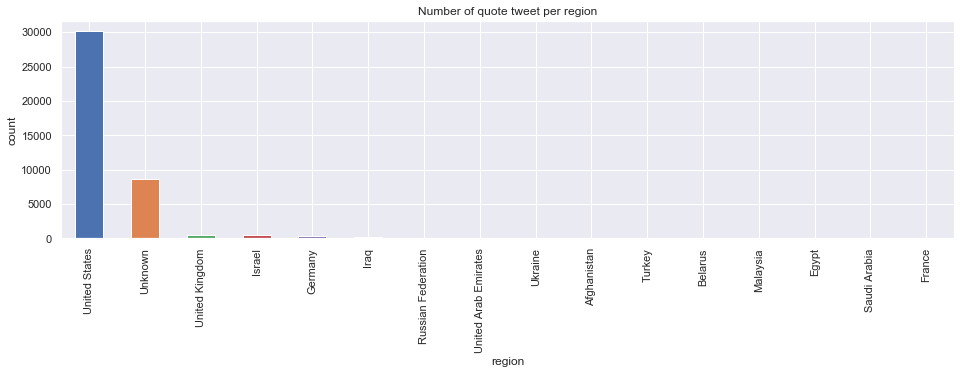

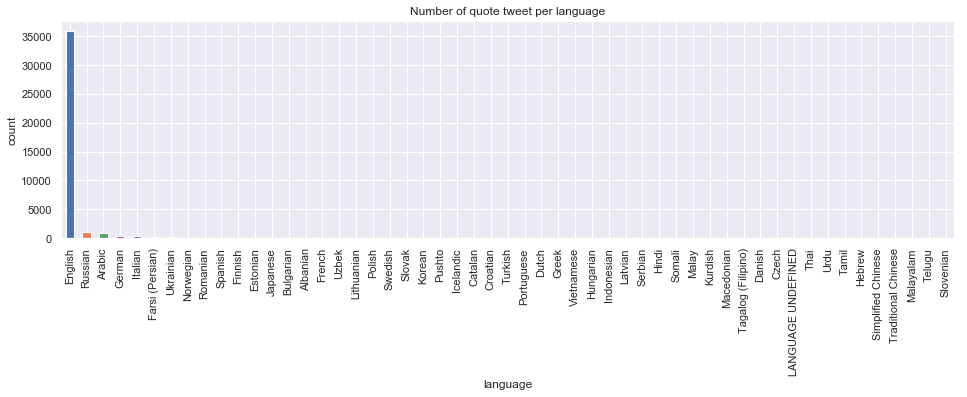

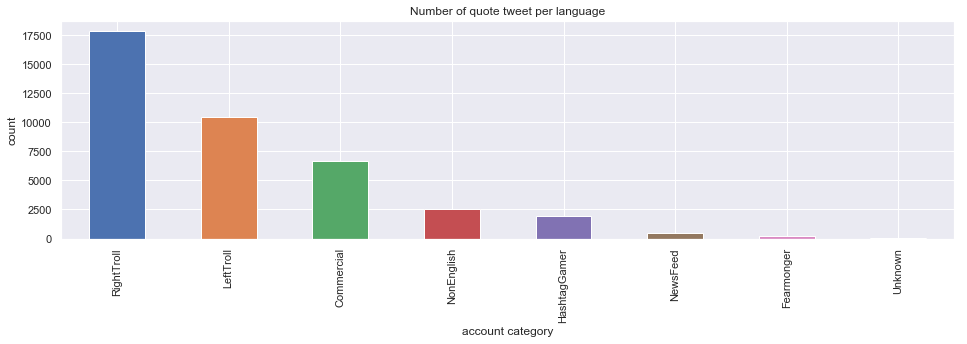

In [7]:
# Select only the quote tweet
quote_tweet_df = kaggle_df.loc[kaggle_df['post_type'] == 'QUOTE_TWEET']

# Plot the number of quote tweet per region
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = quote_tweet_df['region'].value_counts().plot.bar()
ax.set_xlabel('region')
ax.set_ylabel('count')
ax.set_title('Number of quote tweet per region')

# Plot the number of quote tweet per language
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = quote_tweet_df['language'].value_counts().plot.bar()
ax.set_xlabel('language')
ax.set_ylabel('count')
ax.set_title('Number of quote tweet per language')

# Plot the number of quote tweet per account category
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = quote_tweet_df['account_category'].value_counts().plot.bar()
ax.set_xlabel('account category')
ax.set_ylabel('count')
ax.set_title('Number of quote tweet per language')

plt.show()

##### 4.1.2.1.2 Proportion of all tweets (including the retweet) per region/language

In order to see the proportion of tweet corresponding to different features, and to see how we will use the dataset, we will first see how many tweets per region, language and hashtags category have been posted.

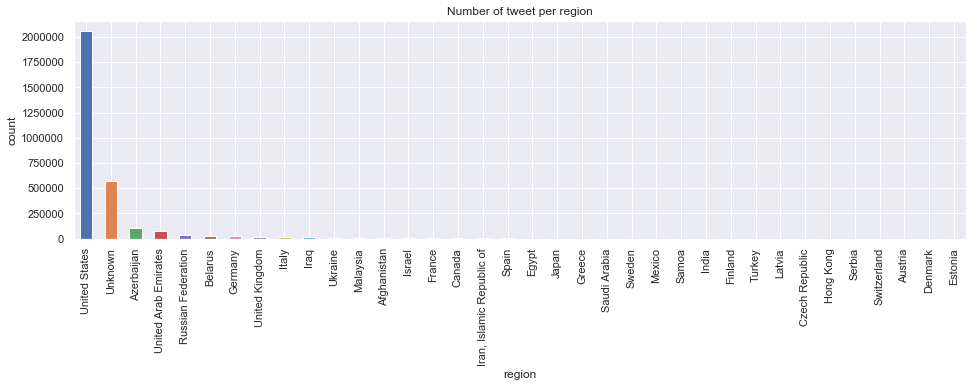

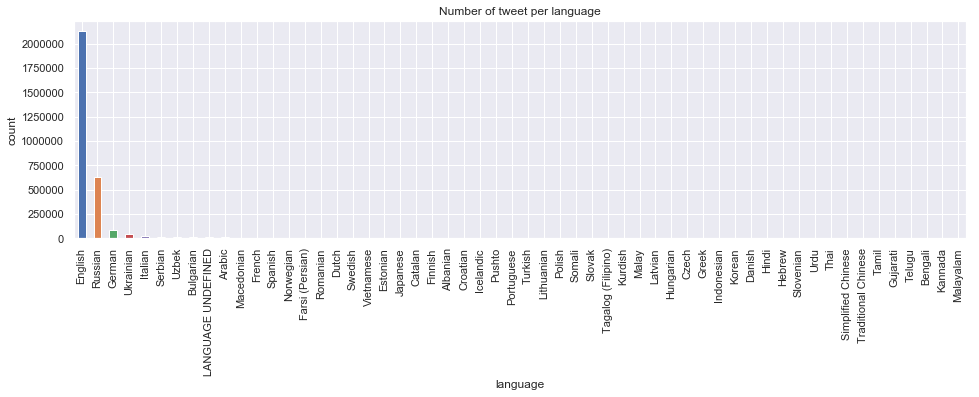

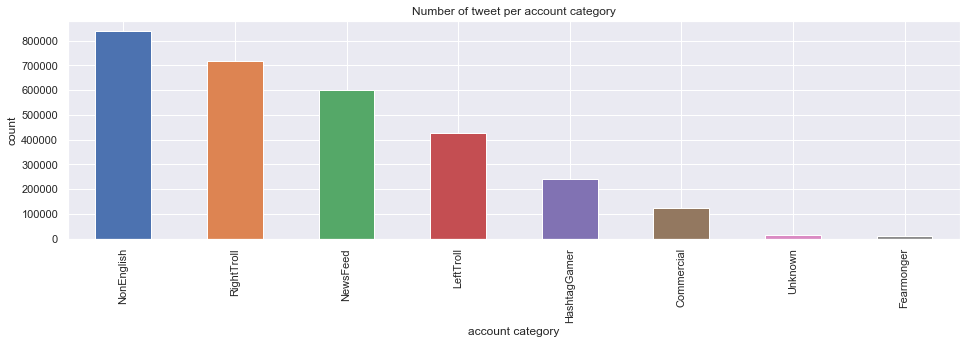

In [8]:
# Plot the number of tweet per region
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = kaggle_df['region'].value_counts().plot.bar()
ax.set_xlabel('region')
ax.set_ylabel('count')
ax.set_title('Number of tweet per region')

# Plot the number of tweet per language
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = kaggle_df['language'].value_counts().plot.bar()
ax.set_xlabel('language')
ax.set_ylabel('count')
ax.set_title('Number of tweet per language')

# Plot the number of tweet per account category
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = kaggle_df['account_category'].value_counts().plot.bar()
ax.set_xlabel('account category')
ax.set_ylabel('count')
ax.set_title('Number of tweet per account category')

plt.show()

In this dataset, we can see that most of the tweets come from the US, and are published in english. This means, that we will keep at least ~200000 tweets for our analysis using this dataset. The main advantage of this dataset, is the classification made by Linvill and Warren, indicating us if the tweet corresponds to a right troll or a left troll (which is very useful in our analysis).

#### 4.1.2.1.3 NaN and unique values for each column of the dataset

To see how to clean this dataset, we first have to see what each column contains (values, number of unknown values, Nan or null values).

In [9]:
# Region
print('*'*70+'\nRegion description : \n')
print('The different regions are : \n {}'.format(kaggle_df['region'].unique()))
N_null = kaggle_df['region'].isnull().sum()
percentage = float(N_null)/float(kaggle_df.shape[0])
print('\nThe number of null values is : {} ({} %)'.format(N_null, 100*percentage))
N_null = kaggle_df[kaggle_df['region'] == 'Unknown'].shape[0]
percentage = float(N_null)/float(kaggle_df.shape[0])
print('The number of unknown values is : {} ({} %)'.format(N_null, 100*percentage))
N_us = kaggle_df[kaggle_df['region'] == 'United States'].shape[0]
print('Number of tweets from US : {} ({} %) of the dataset'.format(N_us, 100*\
                                                           float(N_us)/float(kaggle_df.shape[0])))

# Language
print('*'*70+'\nLanguage description : \n')
print('The different languages are : \n {}'.format(kaggle_df['language'].unique()))
N_null = kaggle_df[kaggle_df['language'] == 'LANGUAGE UNDEFINED'].shape[0]
percentage = float(N_null)/float(kaggle_df.shape[0])
print('\nThe number of LANGUAGE UNDEFINED is : {} ({} %)'.format(N_null, 100*percentage))
N_english = kaggle_df[kaggle_df['language'] == 'English'].shape[0]
print('Number of english tweets : {} ({} %) of the dataset'.format(N_english, 100*\
                                                           float(N_english)/float(kaggle_df.shape[0])))

# Post type
print('*'*70+'\nPost type description : \n')
print('The different post types are : \n {}'.format(kaggle_df['post_type'].unique()))
N_null = kaggle_df['post_type'].isnull().sum()
percentage = float(N_null)/float(kaggle_df.shape[0])
print('\nThe number of null values is : {} ({} %)'.format(N_null, 100*percentage))

# Account type
print('*'*70+'\nAccount type description : \n')
print('The different account types are : \n {}'.format(kaggle_df['account_type'].unique()))
N_null = kaggle_df['account_type'].isnull().sum()
percentage = float(N_null)/float(kaggle_df.shape[0])
print('\nThe number of null values is : {} ({} %)'.format(N_null, 100*percentage))
N_null = kaggle_df[kaggle_df['account_type'] == '?'].shape[0]
percentage = float(N_null)/float(kaggle_df.shape[0])
print('The number of ? is : {} ({} %)'.format(N_null, 100*percentage))

# Account category
print('*'*70+'\nAccount category description : \n')
print('The different account categories are : \n {}'.format(kaggle_df['account_category'].unique()))
N_null = kaggle_df[kaggle_df['account_category'] == 'Unknown'].shape[0]
percentage = float(N_null)/float(kaggle_df.shape[0])
print('The number of unknown values is : {} ({} %)'.format(N_null, 100*percentage))

# Retweet
print('*'*70+'\nRetweet description : \n')
print('The different values for retweet are : \n {}'.format(kaggle_df['retweet'].unique()))
N_null = kaggle_df['retweet'].isnull().sum()
percentage = float(N_null)/float(kaggle_df.shape[0])
print('The number of null values is : {} ({} %)'.format(N_null, 100*percentage))

# Dates
print('*'*70+'\nDates description : \n')
print('The minimum date in the dataset is {}'.format(kaggle_df['publish_date'].min()))
print('The maximum date in the dataset is {}'.format(kaggle_df['publish_date'].max()))
N_null = kaggle_df['publish_date'].isnull().sum()
percentage = float(N_null)/float(kaggle_df.shape[0])
print('\nThe number of null date values is : {} ({} %)'.format(N_null, 100*percentage))

print('*'*70)

**********************************************************************
Region description : 

The different regions are : 
 ['United States' 'Spain' 'Unknown' 'Russian Federation'
 'United Arab Emirates' 'Italy' 'Azerbaijan' nan 'Afghanistan' 'Japan'
 'Germany' 'Saudi Arabia' 'Iraq' 'Israel' 'Egypt' 'Belarus'
 'Iran, Islamic Republic of' 'Mexico' 'Canada' 'France' 'United Kingdom'
 'Ukraine' 'Greece' 'Czech Republic' 'Finland' 'Latvia' 'Estonia'
 'Malaysia' 'Samoa' 'India' 'Turkey' 'Serbia' 'Hong Kong' 'Austria'
 'Sweden' 'Denmark' 'Switzerland']

The number of null values is : 8843 (0.297406546307 %)
The number of unknown values is : 572767 (19.263220096 %)
Number of tweets from US : 2055882 (69.1431375365 %) of the dataset
**********************************************************************
Language description : 

The different languages are : 
 ['English' 'Norwegian' 'Farsi (Persian)' 'French' 'Dutch' 'Vietnamese'
 'Italian' 'Latvian' 'Spanish' 'Lithuanian' 'Albanian' 'Romanian' 

When reading the results above, we can see that if we only keep the interesting language (english), we will only keep 71.6 % of the dataset, which corresponds to about 210000 tweets. We can see (given the analysis of the columns) that a cleaning is not necessary, as all the columns have almost no null values. The only problem can come from the post_type column, but as the column 'retweet' gives us enough informations about the post_type, the only thing to do is to modify the post_type column according to the column 'retweet'.

### 4.2. Dataset from tweeter

#### 4.2.1. Loading the dataset

The rus_troll_tweets dataset, is a subsample (1%) of the total tweets that have been posted by russian account during the elections (till now).

The dataset has different files :

`rus_troll_user.csv` : Contains the user features (nickname, description field, follower count, ...) <br/>
`rus_troll_tweet_text.csv`: Contains the text, and language of each tweet. This is the one we will use to analyse some recurrent text apparition, etc <br/>
`rus_troll_tweet_metadata.csv`: Contains features that are user specific for each tweet <br/>
`rus_troll_tweet_stats.csv`: Contains other tweet features (retweet number, quoted number, ...) <br/>

The column that can appear in each file are descripted below :
* `tweetid` : the id of the tweet (for identification purpose)
* `userid` : the id of the user
* `user_display_name` : the name of the user (encoded for anonymized users)
* `user_screen_name` : Twitter name of the user (encoded for anonymized users)
* `user_reported_location` : location of the user (self-reported) (at the moment of the tweet)
* `user_profile description` : description of the user's profile (at the moment of the tweet)
* `user_profile_url` : Profil URL of the user (at the moment of the tweet)
* `follower_count` : Number of people following the author (at the moment of the tweet)
* `following_count` : Number of people the author is following (at the moment of the tweet)
* `account_creation_date` : time and date of the account creation
* `account_language` : language of the account (chosen by the user)
* `tweet_language` : language of the tweet
* `tweet_text` : content of the tweet (mentions to anonymized accounts have been replaced with anonymized userid)
* `tweet_time` : time when the tweet was published
* `tweet_client_name` : name of the client app used to publish the tweet
* `in_reply_to_tweetid` : the tweetid of the original tweet (if the tweet is reply to another one) (only for replies)
* `in_reply_to_userid` : the userid of the original tweet (if the tweet is reply to another one) (only for replies)
* `quoted_tweet_tweetid` : tweetid of the original tweet (if the tweet is a quote of another one) (only for quotes)
* `is_retweet` : indicates if the tweet is a retweet or not (binary)
* `retweet_userid` : userid who published the original tweet (retweets only)
* `retweet_tweetid` : tweetid of the original tweet (retweets only)
* `latitude` : geo-located latitude (if available)
* `longitude` : geo-located longitude (if available)
* `quote_count` : number of tweets quoting the tweet
* `reply_count` : number of tweets replying to the tweet
* `like_count` : number of like of the tweet
* `retweet_count` : number of retweet of the tweet
* `hashtags` : list of hashtags contained in the tweet
* `urls` : list of urls contained in the tweet
* `user_mentions` : list of userid mentionned in the tweet (anonymized included)
* `poll_choices` : poll choices (if the tweet includes a poll)

In [10]:
user_df = pd.read_csv(PATH_DATA + '/rus_troll_user.csv')
metadata_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_metadata.csv')
stats_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_stats.csv')
text_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_text.csv')

print('*'*66)
print('The shape of the user dataframe is : {}'.format(user_df.shape))
print('The shape of the metadata dataframe is : {}'.format(metadata_df.shape))
print('The shape of the stats dataframe is : {}'.format(stats_df.shape))
print('The shape of the text dataframe is : {}'.format(text_df.shape))
print('*'*66)

/Users/adrien/miniconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


******************************************************************
The shape of the user dataframe is : (3667, 11)
The shape of the metadata dataframe is : (9041308, 6)
The shape of the stats dataframe is : (9041308, 17)
The shape of the text dataframe is : (9041308, 3)
******************************************************************


#### 4.2.2. Dataset description
To understand what fields are contained in each csv files, and what files we may need, we can first plot the columns of each dataframe :

In [11]:
# user
print('*'*70+'\nuser dataframe : \n')
print('The fields for user dataframe are : \n{}'.format(user_df.columns.tolist()))

# metadata
print('*'*70+'\nmetadata dataframe : \n')
print('The fields for metadata dataframe are : \n{}'.format(metadata_df.columns.tolist()))

# stats
print('*'*70+'\nstats dataframe : \n')
print('The fields for stats dataframe are : \n{}'.format(stats_df.columns.tolist()))

# text
print('*'*70+'\ntext dataframe : \n')
print('The fields for text dataframe are : \n{}'.format(text_df.columns.tolist()))

# number of tweets
print('*'*70)
print('\nThe number of tweets are for : \nmetadata: {} \nstats: {} \ntext: {}'.\
      format(metadata_df.shape[0],stats_df.shape[0],text_df.shape[0]))

print('*'*70)

**********************************************************************
user dataframe : 

The fields for user dataframe are : 
['userid', 'user_display_name', 'user_screen_name', 'user_reported_location', 'user_profile_description', 'user_profile_url', 'account_creation_date', 'account_language', 'follower_count', 'following_count', 'last_tweet_at']
**********************************************************************
metadata dataframe : 

The fields for metadata dataframe are : 
['tweetid', 'follower_count', 'following_count', 'latitude', 'longitude', 'tweet_client_name']
**********************************************************************
stats dataframe : 

The fields for stats dataframe are : 
['tweetid', 'userid', 'tweet_time', 'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet', 'retweet_userid', 'retweet_tweetid', 'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags', 'urls', 'user_mentions', 'poll_choices']
*******************

We can see here that we have a total of about 9M of tweets for a total of about 4k of users, and given the columns of each dataframe, we can choose the columns we want to keep for our analysis.

For the stats dataframe :
* `tweetid`
* `userid`
* `tweet_time`
* `in_reply_to_tweetid`
* `in_reply_to_userid`
* `quoted_tweet_tweetid`
* `is_retweet`
* `retweet_userid`
* `retweet_tweetid`
* `quote_count`
* `reply_count`
* `like_count`
* `retweet_count`
* `hashtags`
* `urls`
* `user_mentions`
* `poll_choices`

For the text dataframe :
* `tweetid`
* `tweet_language`
* `tweet_text`

For the metadata dataframe :
* `tweetid`
* `follower_count`
* `following_count`
* `latitude`
* `longitude`

As for the moment, our analysis in not based on the users, we don't need the user dataframe. But depending on the future features we might need, it is possible that we finally use this dataframe.

##### 4.2.2.1 Proportion of tweet per language

***************************************************************************
Number of tweet in english : 3261931 (36.0780873741 % of the dataset)
***************************************************************************


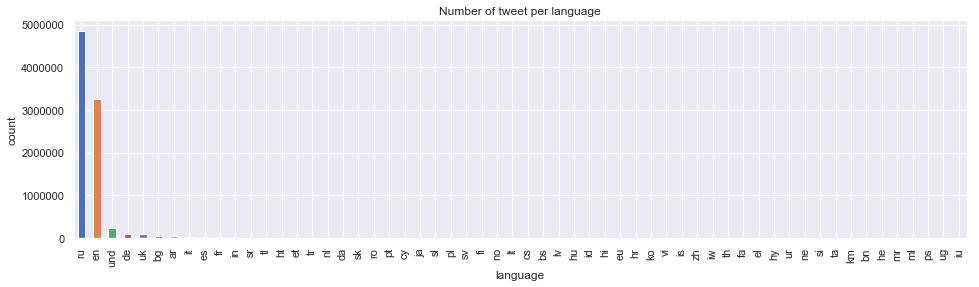

In [12]:
# Plot the number of quote tweet per language
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = text_df['tweet_language'].value_counts().plot.bar()
ax.set_xlabel('language')
ax.set_ylabel('count')
ax.set_title('Number of tweet per language')

# number of tweets
N_english = text_df[text_df['tweet_language'] == 'en'].shape[0]
print('*'*75)
print('Number of tweet in english : {} ({} % of the dataset)'.format(N_english, 100*\
                                                     float(N_english)/float(text_df['tweet_language'].shape[0])))

print('*'*75)

plt.show()

##### 4.2.2.2 Proportion of quote tweet, reply, retweet and requote

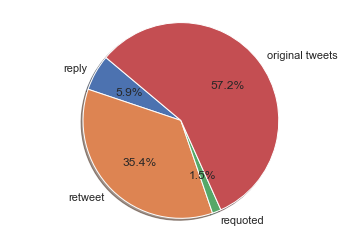

In [13]:
stats_df['tweet_type'] = 'original'
reply_index = (stats_df['in_reply_to_tweetid'].notnull()) | (stats_df['in_reply_to_userid'].notnull())
retweet_index = (stats_df['is_retweet'] == True) & (stats_df['quoted_tweet_tweetid'].isnull())
requoted_index = (stats_df['is_retweet'] == True) & (stats_df['quoted_tweet_tweetid'].notnull())
stats_df.loc[reply_index,'tweet_type'] = 'reply'
stats_df.loc[retweet_index ,'tweet_type'] = 'retweet'
stats_df.loc[requoted_index,'tweet_type'] = 'requoted'
plt.pie([reply_index.sum(),retweet_index.sum(),requoted_index.sum(),(stats_df['tweet_type'] == 'original').sum()],
        labels=['reply','retweet','requoted','original tweets'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

##### 4.2.2.3 Number of tweets in function of time

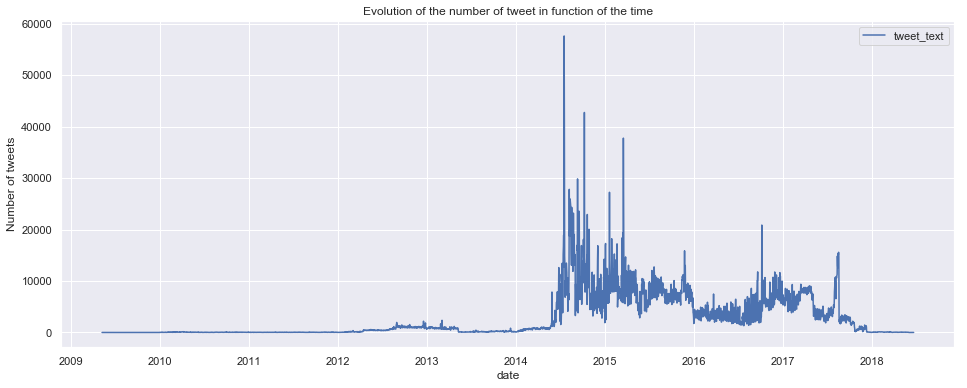

In [14]:
dataset = stats_df.merge(text_df, how= 'inner', on='tweetid')
dataset = dataset.merge(metadata_df, how= 'inner', on='tweetid')
dataset['date'] = pd.to_datetime(dataset['tweet_time'], format='%Y-%m-%d %H:%M').dt.date

ax = dataset[['date', 'tweet_text']].groupby('date').count().plot(figsize=[16, 6])
ax.set_ylabel('Number of tweets')
ax.set_title('Evolution of the number of tweet in function of the time')
plt.show()

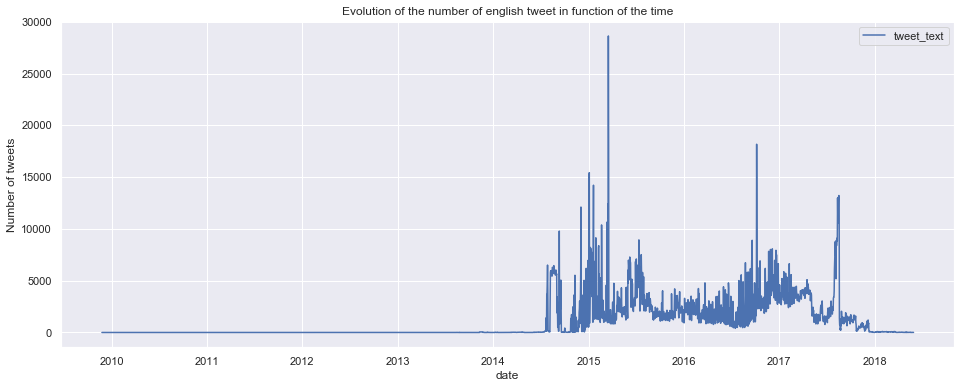

In [15]:
ax = dataset.loc[dataset['tweet_language'] == 'en',['date', 'tweet_text']].groupby('date').count().plot(figsize=[16, 6])
ax.set_ylabel('Number of tweets')
ax.set_title('Evolution of the number of english tweet in function of the time')
plt.show()

As we can see, there are three main peaks on the number of tweets in this dataset. One in the early 2015 which maybe corresponds with the beginning of the elections, and the second one (late 2016) maybe corresponds to the final round of the elections. The third one maybe comes from later scandale that may have appeared after the elections (mid-2018)

##### 4.2.2.4  NaN and unique values for each column of the dataset

In [16]:
for feature in dataset.columns:
    print(70*'*'+'\nFor the feature : %s' %(feature ))
    N_null = dataset[feature].isnull().sum()
    percentage = float(N_null)/float(dataset.shape[0])
    print('The number of null values is : {} ({} %)'.format(N_null, 100*percentage))
print(70*'*')

**********************************************************************
For the feature : tweetid
The number of null values is : 0 (0.0 %)
**********************************************************************
For the feature : userid
The number of null values is : 0 (0.0 %)
**********************************************************************
For the feature : tweet_time
The number of null values is : 0 (0.0 %)
**********************************************************************
For the feature : in_reply_to_tweetid
The number of null values is : 8775100 (97.0556472581 %)
**********************************************************************
For the feature : in_reply_to_userid
The number of null values is : 8503421 (94.0507833601 %)
**********************************************************************
For the feature : quoted_tweet_tweetid
The number of null values is : 8853395 (97.9216170935 %)
**********************************************************************
For the feature

As we can see here, most of the features don't have null values. The only ones that may have null values are : `in_reply_to_tweetid`, `in_reply_to_userid`, `quoted_tweet_tweetid`, `retweet_userid`, `retweet_tweetid`, `hashtags`, `latitude` and `longitude`.

For `hashtags`, some tweets can simply not contain any hashtags. But as our analysis will taking into account the text of the tweet, it is not a problem. `latitude` and `longitude` fields are not always available, which explains why they are almost always null. This means, that our analysis won't be axed on the regions of the tweets given by these two features.

For all the other one, it is normal that they are sometimes null, as they are only available if the tweet is a retweet, a reply, or a quote.

### 4.3 Voters survey

In this dataset, there are 27 different features, but we will keep only the following :
* `state` : state where the poll has been made
* `startdate` : start date of the poll
* `enddate` : end date of the poll
* `samplesize` : number of people that have been questionned
* `poll_wt` : weight of the poll
* `rawpoll_clinton` : raw poll of results for clinton
* `rawpoll_trump` : raw poll of results for trump
* `rawpoll_johnson` : raw poll of results for johnson
* `adjpoll_clinton` : adjusted poll of results for clinton (weighted with the whole population of the state)
* `adjpoll_trump` : adjusted poll of results for trump (weighted with the whole population of the state)
* `adjpoll_johnson` : adjusted poll of results for johnson (weighted with the whole population of the state)

Here we don't keep the results for mcmullin, as almost all the values are not defined.

In [17]:
voter_df = pd.read_csv(PATH_DATA + '/presidential_polls.csv', usecols=['state', 'startdate', 'enddate', 'samplesize', 
           'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson',
           'adjpoll_clinton', 'adjpoll_trump', 'adjpoll_johnson'])

print('*'*66)
print('The shape of the voter dataframe is the following : {}'.format(voter_df.shape))
print('*'*66)

voter_df.head()

******************************************************************
The shape of the voter dataframe is the following : (10236, 11)
******************************************************************


state   startdate     enddate  samplesize   poll_wt  rawpoll_clinton  \
0      U.S.  10/25/2016  10/31/2016     24316.0  6.139129            37.69   
1      U.S.  10/27/2016  10/30/2016      1128.0  4.197292            45.00   
2  Virginia  10/27/2016  10/30/2016      1024.0  3.876856            48.00   
3   Florida  10/20/2016  10/24/2016      1251.0  3.403096            48.00   
4      U.S.  10/20/2016  10/25/2016      2120.0  3.394646            46.00   

   rawpoll_trump  rawpoll_johnson  adjpoll_clinton  adjpoll_trump  \
0          35.07             6.18         42.64140       40.86509   
1          46.00             3.00         43.29659       44.72984   
2          42.00             6.00         46.29779       40.72604   
3          45.00             2.00         46.35931       45.30585   
4          40.00             6.00         45.32744       42.20888   

   adjpoll_johnson  
0         5.675099  
1         3.401513  
2         6.401513  
3         1.777730  
4         3.618320

#### 4.3.1 Dataset description
To describe the dataset, we will first look for all the nan or null values.

In [18]:
for col in voter_df.columns:
    print(70*'*'+'\nFor column : %s' %(col ))
    N_null = voter_df[col].isnull().sum()
    percentage = float(N_null)/float(voter_df.shape[0])
    print('The number of null values is : {} ({} %)'.format(N_null, 100*percentage))
print(70*'*')

**********************************************************************
For column : state
The number of null values is : 0 (0.0 %)
**********************************************************************
For column : startdate
The number of null values is : 0 (0.0 %)
**********************************************************************
For column : enddate
The number of null values is : 0 (0.0 %)
**********************************************************************
For column : samplesize
The number of null values is : 3 (0.0293083235639 %)
**********************************************************************
For column : poll_wt
The number of null values is : 0 (0.0 %)
**********************************************************************
For column : rawpoll_clinton
The number of null values is : 0 (0.0 %)
**********************************************************************
For column : rawpoll_trump
The number of null values is : 0 (0.0 %)
****************************************

For `samplesize` feature, we can see below that the only threes values are null. We won't remove these samples, as we may be more interested into results that are coresponding to the general vote (state = us).

The other possible null values are for the column `rawpoll_johnson`, `adjpoll_johnson` which corresponds to the moment where only the two remaining candidates were selected (Trump and Clinton). This is why, we may work with these columns at the beginning of the campaign (to see if the influence of the tweet may have made more people vote for johnson istead of Trump or Clinton).

In [19]:
voter_df[voter_df['samplesize'].isnull()]

state  startdate    enddate  samplesize   poll_wt  rawpoll_clinton  \
1284  Illinois  7/11/2016  7/12/2016         NaN  0.029780             46.4   
4878  Illinois  7/11/2016  7/12/2016         NaN  0.017206             46.4   
8109  Illinois  7/11/2016  7/12/2016         NaN  0.029780             46.4   

      rawpoll_trump  rawpoll_johnson  adjpoll_clinton  adjpoll_trump  \
1284           32.5              5.2         49.28047       35.69393   
4878           32.5              5.2         49.27000       35.93928   
8109           32.5              5.2         49.28476       35.72319   

      adjpoll_johnson  
1284         2.286038  
4878         2.335123  
8109         2.313945

#### 4.3.1.1 Evolution of the voting intention

/Users/adrien/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


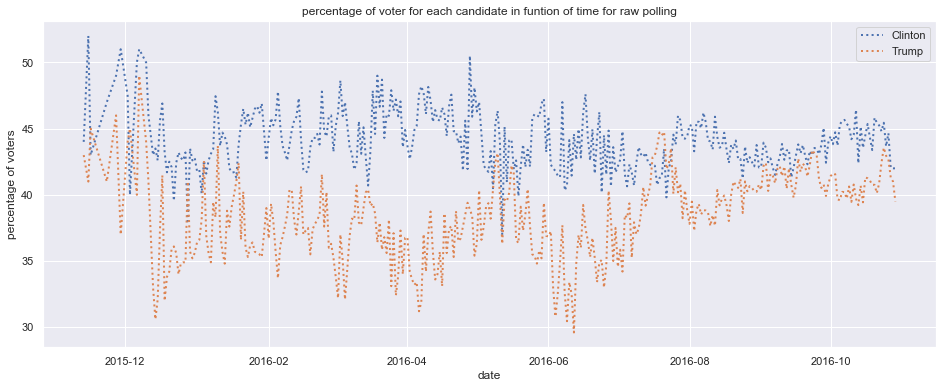

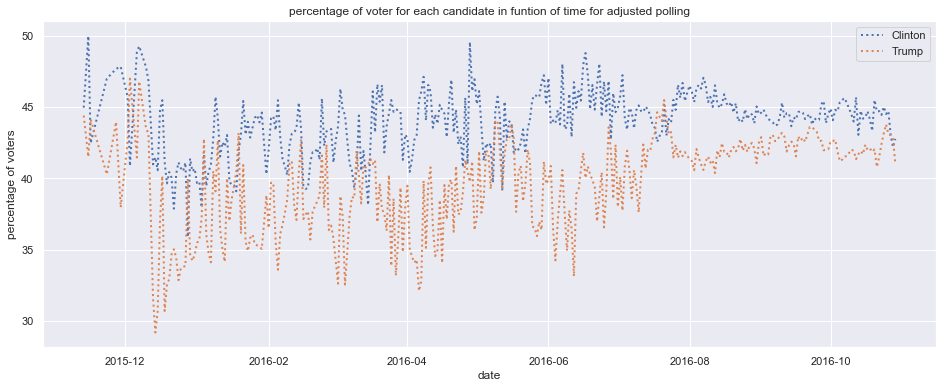

In [20]:
ind_us = voter_df['state'] == 'U.S.'
voter_us_df = voter_df.loc[ind_us]
voter_us_df['date'] = pd.to_datetime(voter_us_df['startdate'], format='%m/%d/%Y').dt.date

# Raw poll results
ax = voter_us_df[['date', 'rawpoll_clinton', 'rawpoll_trump']].groupby('date').mean().plot(figsize=(16,6), \
                                                                                           linestyle=':', linewidth=2)

ax.set_xlabel('date')
ax.set_ylabel('percentage of voters')
ax.set_title('percentage of voter for each candidate in funtion of time for raw polling')
ax.legend(['Clinton', 'Trump'])

# Adjusted poll results
ax = voter_us_df[['date', 'adjpoll_clinton', 'adjpoll_trump']].groupby('date').mean().plot(figsize=(16,6), \
                                                                                           linestyle=':', linewidth=2)

ax.set_xlabel('date')
ax.set_ylabel('percentage of voters')
ax.set_title('percentage of voter for each candidate in funtion of time for adjusted polling')
ax.legend(['Clinton', 'Trump'])

plt.show()

We can see here, that as we approach of the elections, the general tendency to vote for Trump has increased compare to the one of Clinton (slightly decreased and then stayed almost constant). This can be explained by the fact that Trump made up the electors from the other candidates.

## 5. Cleaning the datasets

Firt of all after analysing both dataset, we choose to use the twitter dataset because it has more tweets and has more statistic and metadata, however we loose the troll type category. We will try to retreive it in the future.

In order to use the dataset, we first have to clean it. For this purpose, we will study, and select only certain row according to the following criteriae :
* First, we suppose that only the english tweet will be used. Indeed, as the disinformation is supposed to be done in USA, it is relevant to keep only the tweet that have been posted in english.
* Second, Donald Trump has been elected officially the 19th of december 2016. As the primary to these elections have begun on february the same year, it can be relevant to keep an interval of one year before the elections date.
* Thirdly, some tweets are posted in one sentence, delimited by capital letters. In this case, the one word sentences have to be separated to help the research in a easier manner. However, alle the tweets can be posted with capital letters, so, for easier computations, it is more relevant to cast them in only lowercase sentences.


#### The dataset is loaded (again) as follow: (no need to do the analyse above)
1- Load text and keep only english tweets<br>
2- Load stats and we select only the wanted time interval<br>
3- Inner merge between zext and stats <br>
4- Load metadata and merge <br>

In [2]:
# Load first text to select only english tweets
text_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_text.csv', encoding="utf-8")
english_index = text_df['tweet_language'] == 'en'
new_N = english_index.sum()
old_N = text_df.shape[0]
print('Taken only enlish tweets: {} % of the dataframe have been kept'.format(float(new_N)/float(old_N)*100))
text_df = text_df.loc[english_index]


# Load stats to select only english tweets
stats_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_stats.csv', usecols = ['tweetid', 'userid', 'tweet_time', 
        'in_reply_to_tweetid', 'in_reply_to_userid', 'quoted_tweet_tweetid', 'is_retweet', 'retweet_userid', 
        'retweet_tweetid', 'quote_count', 'reply_count', 'like_count', 'retweet_count', 'hashtags'], encoding="utf-8")
# Keep only interesting time interval
start_date = '2015-04-12 00:00'
end_date = '2016-11-08 23:59'
print('Previous time interval is : {} -> {}'.format(stats_df['tweet_time'].min(), stats_df['tweet_time'].max()))
old_N = stats_df.shape[0]
stats_df = stats_df[(stats_df['tweet_time'] >= start_date) & (stats_df['tweet_time'] <= end_date)]
print('New time interval is : {} -> {}'.format(stats_df['tweet_time'].min(), stats_df['tweet_time'].max()))
new_N = stats_df.shape[0]
print('For the time interval : {} % of the dataframe have been kept'.format(float(new_N)/float(old_N)*100))


# Then Merge the metadata
dataset = text_df.merge(stats_df,how = 'inner', on = 'tweetid')
print('For the english tweets and  time interval  : {} % of the dataframe have been kept'\
      .format(float(dataset.shape[0])/float(old_N)*100))
metadata_df = pd.read_csv(PATH_DATA + '/rus_troll_tweet_metadata.csv', encoding="utf-8")
dataset = dataset.merge(metadata_df,how = 'inner', on = 'tweetid')

Taken only enlish tweets: 36.07808737408348 % of the dataframe have been kept
Previous time interval is : 2009-05-09 15:59 -> 2018-06-21 14:32
New time interval is : 2015-04-12 00:00 -> 2016-11-08 23:59
For the time interval : 36.3465330458823 % of the dataframe have been kept
For the english tweets and  time interval  : 15.723189609291044 % of the dataframe have been kept


** Then, we add a new feature to classify between reply, retweet, requoted and original tweets and plot the repartition **

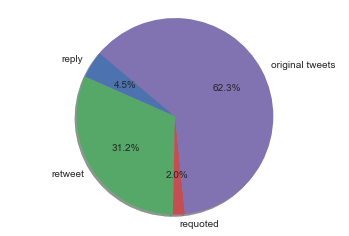

In [3]:
dataset['date'] = pd.to_datetime(dataset['tweet_time'], format='%Y-%m-%d %H:%M').dt.date

dataset['tweet_type'] = 'original'
reply_index = (dataset['in_reply_to_tweetid'].notnull()) | (dataset['in_reply_to_userid'].notnull())
retweet_index = (dataset['is_retweet'] == True) & (dataset['quoted_tweet_tweetid'].isnull())
requoted_index = (dataset['is_retweet'] == True) & (dataset['quoted_tweet_tweetid'].notnull())
dataset.loc[reply_index,'tweet_type'] = 'reply'
dataset.loc[retweet_index ,'tweet_type'] = 'retweet'
dataset.loc[requoted_index,'tweet_type'] = 'requoted'
plt.pie([reply_index.sum(),retweet_index.sum(),requoted_index.sum(),(dataset['tweet_type'] == 'original').sum()],
        labels=['reply','retweet','requoted','original tweets'],autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

#### The text is process as follow:
1- hastags are removed (already on a column)<br>
2- Remove RT at the beginning, @user_id and http<br>
3- Replace smiley with meaning <br>
4- Replace wrong conjugaison <br>
5- Remove unwanted ponctuation <br>
6- Words are set to lower keys <br>
7- Add a feature of list of words tokenized <br>
7- Add a feature of list of words stemmers (Stemmers remove morphological affixes from words, leaving only the word stem) <br>

In [4]:
def clean_str(string):
    # remove RT and user_id 
    string = re.sub(r'http\S*', ' ', string)
    string = re.sub(r'@\S*', ' ', string)
    string = re.sub(r'^RT ', ' ', string)
    # Replaced smily with meaning
    string = re.sub(r'\:\)', ' happy ', string)
    string = re.sub(r'\:\(', ' sad ', string)
    string = re.sub(r'\:\/', ' sarcasm ', string)
    string = re.sub(r'\<\d', ' love ', string)
    string = re.sub(r'&', ' and ', string)
    # Change the conjugaison
    string = re.sub(r"what's ", "what is ", string)
    string = re.sub(r"\'s ", " is ", string)
    string = re.sub(r"\'ve ", " have ", string)
    string = re.sub(r"can't ", "cannot ", string)
    string = re.sub(r"n't ", " not ", string)
    string = re.sub(r"i'm ", " i am ", string)
    string = re.sub(r"i've ", " i have ", string)
    string = re.sub(r"youre ", " you are ", string)
    string = re.sub(r"it's ", " it is ", string)
    string = re.sub(r"\'re ", " are ", string)
    string = re.sub(r"\'d ", " would ", string)
    string = re.sub(r"\'ll ", " will ", string)
    string = re.sub(r"don't ", " dont ", string)
    string = re.sub(r"im ", " i am ", string)
    # change the ponctuation 
    string = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", string)
    string = re.sub(r"\d", " ", string) 
    string = re.sub(r"\d", " ", string) 
    string = re.sub(r",", " ", string)
    string = re.sub(r":", " ", string)
    string = re.sub(r"\.", " ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\/", " ", string)
    string = re.sub(r"\^", " ^ ", string)
    string = re.sub(r"\+", " + ", string)
    string = re.sub(r"\-", " - ", string)
    string = re.sub(r"\=", " = ", string)
    string = re.sub(r"'", " ", string)
    string = re.sub(r"(\d+)(k)", r"\g<1>000", string)
    string = re.sub(r":", " : ", string)
    string = re.sub(r"\0s", "0", string)
    string = re.sub(r"e - mail", "email", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()


def clean_tweets(text):
    # First remove hashtags from the text then pass throught regular expressions above
    for hastag in text['hashtags'].strip('][').split(', '):
        text['tweet_text'] = text['tweet_text'].replace('#'+hastag,"")
    text['tweet_text'] = clean_str(text['tweet_text'])
    return text['tweet_text']



In [5]:
dataset['tweet_text_clean'] = dataset.apply(lambda x: clean_tweets(x),axis=1)
dataset['words_tokenized'] = dataset.apply(lambda x: word_tokenize(x['tweet_text_clean']),axis=1) 

In [6]:
dataset['hashtags'] = dataset.apply(lambda x: [hashtag for hashtag in x['hashtags'].strip('][').split(', ')],axis=1)

In [7]:
stop_words = stopwords.words('english') + [' ','-','#','!','"','$','%','&','()','*','+',',','.','/',':',';','<','=','>',
                                           '?','@','[',']','^','_','{','|','}','~',']','&amp', 'amp','rt']

stemmer = SnowballStemmer("english")
dataset['words_stem'] = dataset.apply(lambda x: [stemmer.stem(word) for word in x['words_tokenized'] if word not in stop_words],axis=1)

In [8]:
# FastText need a string as input so we join words in words_stem column
dataset['tweets_stem'] = dataset.apply(lambda x: ' '.join(x['hashtags'] + x['words_stem']),axis = 1)

In [9]:
dataset[['tweet_text','tweet_text_clean','hashtags','words_tokenized','words_stem','tweets_stem']].head(10)

tweet_text  \
0  RT @e933848ee109a3e968bfefb54a785c0426edab39c1...   
1          I need this skill https://t.co/2X4DHRVp2W   
2  RT @Herobright2: @UNHumanRights NIGERIA CRIES ...   
3  RT @74c5eb30de3d6691e150879ee8528463c70b0feaef...   
4  #IfAnimalsMadeLaws all parrots would be equal ...   
5  Muslims can't even coexist with Muslims Why do...   
6  @CapLarryDart @Co_Passenger won't stricter gun...   
7  And who will determine what exactly is #offens...   
8                                     @BBCWorld yeap   
9  You know that fat girls who believe in #BodyAc...   

                                    tweet_text_clean  \
0  saw it several days ago during a trip and that...   
1                                  i need this skill   
2        nigeria cries out avengers have finished us   
3  you seen the video of the police tellin is kil...   
4      all parrots would be equal from the beginning   
5  muslims cannot even coexist with muslims why d...   
6  wo not stricter gun control change the situati...   
7             and who will determine what exactly is   
8                                               yeap   
9  you know that fat girls who believe in usually...   

                                hashtags  \
0                                     []   
1                                     []   
2                                     []   
3  [WearHoodieForTrayvon, TrayvonMartin]   
4    [IfAnimalsMadeLaws, EqualityForAll]   
5                                     []   
6                                     []   
7                            [offensive]   
8                                     []   
9                       [BodyAcceptance]   

                                     words_tokenized  \
0  [saw, it, several, days, ago, during, a, trip,...   
1                             [i, need, this, skill]   
2  [nigeria, cries, out, avengers, have, finished...   
3  [you, seen, the, video, of, the, police, telli...   
4  [all, parrots, would, be, equal, from, the, be...   
5  [muslims, can, not, even, coexist, with, musli...   
6  [wo, not, stricter, gun, control, change, the,...   
7     [and, who, will, determine, what, exactly, is]   
8                                             [yeap]   
9  [you, know, that, fat, girls, who, believe, in...   

                                          words_stem  \
0      [saw, sever, day, ago, trip, amaz, see, face]   
1                                      [need, skill]   
2                  [nigeria, cri, aveng, finish, us]   
3  [seen, video, polic, tellin, killer, happen, n...   
4                      [parrot, would, equal, begin]   
5  [muslim, even, coexist, muslim, believ, live, ...   
6  [wo, stricter, gun, control, chang, situat, re...   
7                                  [determin, exact]   
8                                             [yeap]   
9  [know, fat, girl, believ, usual, shame, thin, ...   

                                         tweets_stem  
0               saw sever day ago trip amaz see face  
1                                         need skill  
2                        nigeria cri aveng finish us  
3  WearHoodieForTrayvon TrayvonMartin seen video ...  
4  IfAnimalsMadeLaws EqualityForAll parrot would ...  
5   muslim even coexist muslim believ live peac m...  
6   wo stricter gun control chang situat realli n...  
7                           offensive determin exact  
8                                               yeap  
9  BodyAcceptance know fat girl believ usual sham...

### Recolect category from the kaggle dataset

In [10]:
# open kaggle dataset 
filenames = glob.glob(os.path.join(PATH_DATA, "IRAhandle_tweets_*.csv"))
kaggle_df = pd.concat((pd.read_csv(f,encoding= 'utf-8') for f in filenames))

In [11]:
# merge dataset on content
dataset = dataset.merge(kaggle_df[['content','account_category']], how = 'left',
                        left_on = 'tweet_text', right_on = 'content').drop(columns='content')
dataset.head(10)

tweetid tweet_language  \
0  631377234847248384             en   
1  653251376760295425             en   
2  784084336307863552             en   
3  703231561299136512             en   
4  626740121648259072             en   
5  681897201761697792             en   
6  662532293613875201             en   
7  668044460224188416             en   
8  607812929568636928             en   
9  728636801242566657             en   

                                          tweet_text  \
0  RT @e933848ee109a3e968bfefb54a785c0426edab39c1...   
1          I need this skill https://t.co/2X4DHRVp2W   
2  RT @Herobright2: @UNHumanRights NIGERIA CRIES ...   
3  RT @74c5eb30de3d6691e150879ee8528463c70b0feaef...   
4  #IfAnimalsMadeLaws all parrots would be equal ...   
5  Muslims can't even coexist with Muslims Why do...   
6  @CapLarryDart @Co_Passenger won't stricter gun...   
7  And who will determine what exactly is #offens...   
8                                     @BBCWorld yeap   
9  You know that fat girls who believe in #BodyAc...   

                                              userid        tweet_time  \
0  065bd0ec43552000636a4e547ad8805d0c78525c8c765a...  2015-08-12 08:10   
1                                         2882350436  2015-10-11 16:50   
2  8e58ab0f46d273103d9e71aa92cdaffb6e330ec7d15ae5...  2016-10-06 17:34   
3  8e58ab0f46d273103d9e71aa92cdaffb6e330ec7d15ae5...  2016-02-26 14:54   
4                                         2882331822  2015-07-30 13:04   
5                                         2882331822  2015-12-29 17:58   
6                                         2882331822  2015-11-06 07:29   
7                                         2882331822  2015-11-21 12:33   
8                                         2882331822  2015-06-08 07:34   
9                                         2882331822  2016-05-06 17:25   

   in_reply_to_tweetid in_reply_to_userid  quoted_tweet_tweetid  is_retweet  \
0                  NaN                NaN                   NaN        True   
1                  NaN                NaN          6.532436e+17       False   
2                  NaN                NaN                   NaN        True   
3                  NaN                NaN                   NaN        True   
4                  NaN                NaN                   NaN       False   
5                  NaN                NaN                   NaN       False   
6         6.623995e+17          164332083                   NaN       False   
7                  NaN                NaN                   NaN       False   
8         6.078118e+17             742143                   NaN       False   
9                  NaN                NaN                   NaN       False   

                                      retweet_userid        ...         \
0  e933848ee109a3e968bfefb54a785c0426edab39c144c0...        ...          
1                                                NaN        ...          
2                                         2683299690        ...          
3  74c5eb30de3d6691e150879ee8528463c70b0feaefed97...        ...          
4                                                NaN        ...          
5                                                NaN        ...          
6                                                NaN        ...          
7                                                NaN        ...          
8                                                NaN        ...          
9                                                NaN        ...          

   latitude  longitude   tweet_client_name        date  tweet_type  \
0       NaN        NaN  Twitter Web Client  2015-08-12     retweet   
1       NaN        NaN  Twitter Web Client  2015-10-11    original   
2       NaN        NaN  Twitter Web Client  2016-10-06     retweet   
3       NaN        NaN  Twitter Web Client  2016-02-26     retweet   
4       NaN        NaN  Twitter Web Client  2015-07-30    original   
5       NaN        NaN  Twitter Web 

In [12]:
nb_word = 20000

# Split between categorize and uncategorize:
train_index = dataset['account_category'].notnull()
test_index = dataset['account_category'].isnull()
train = dataset.loc[train_index,'tweets_stem']
test = dataset.loc[test_index,'tweets_stem']
sequence_length = max(len(x) for x in train)

# Vectorize the text samples into a 2D integer tensor with Tokenizer
tokenizer = Tokenizer(num_words=nb_word)
tokenizer.fit_on_texts(train)
sequences_train = tokenizer.texts_to_sequences(train)
sequences_test = tokenizer.texts_to_sequences(test)

In [14]:
# create labels
i =0
label_dict = {}
for label in dataset.loc[train_index,'account_category'].unique():
    label_dict[label] = i
    i=i+1
inv_label_dict = {v: k for k, v in label_dict.items()}

labels = to_categorical(dataset.loc[train_index,'account_category'].replace(label_dict))

In [15]:
# randomize data
num_row = len(labels)
indices = np.random.permutation(num_row)
train = pad_sequences(sequences_train, maxlen=sequence_length)[indices]
label_train=labels[indices]
test = pad_sequences(sequences_test, maxlen=sequence_length)

In [16]:
embedding_dim = 20
filters = [2,3]
num_filters = 10
drop = 0.6

nb_epoch = 1
batch_size = 50

convolutions = []
# this returns a tensor
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=nb_word + 1,
                            output_dim=embedding_dim,
                            input_length=sequence_length,
                            trainable=True)(inputs)
for nb_filter in filters:
    conv = Convolution1D(num_filters, nb_filter, activation='relu')(embedding)
    maxpooling = AveragePooling1D(2)(conv)
    flatten=Flatten()(maxpooling)
    convolutions.append(flatten)

merged_tensor = Concatenate(axis=1)(convolutions)
dense0=Dense(60,init='uniform', activation='relu')(merged_tensor)
dropout0 = Dropout(drop)(dense0)
dense1=Dense(40,init='uniform', activation='relu')(dropout0)
dropout1 = Dropout(drop)(dense1)
out = Dense(output_dim=8, init='uniform',activation='softmax')(dropout1)



model = Model(input=inputs, output=out)

Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0005)

model.compile(loss='binary_crossentropy',
                                          optimizer=Adam,
                                          metrics=['accuracy'])
model.fit(train, label_train,
          epochs=nb_epoch ,
          batch_size=batch_size, class_weight = 'balanced')



C:\Users\Aindy\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(60, activation="relu", kernel_initializer="uniform")`
C:\Users\Aindy\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(40, activation="relu", kernel_initializer="uniform")`
C:\Users\Aindy\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=8, kernel_initializer="uniform")`
C:\Users\Aindy\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/1
859263/859263 [==============================] - 277s 322us/step - loss: 0.1562 - acc: 0.9421


In [17]:
dataset.loc[test_index,'account_category'] = np.argmax(model.predict(test, batch_size=None),axis=1)
dataset['account_category'].replace(inv_label_dict,inplace = True)
dataset.head()

tweetid tweet_language  \
0  631377234847248384             en   
1  653251376760295425             en   
2  784084336307863552             en   
3  703231561299136512             en   
4  626740121648259072             en   

                                          tweet_text  \
0  RT @e933848ee109a3e968bfefb54a785c0426edab39c1...   
1          I need this skill https://t.co/2X4DHRVp2W   
2  RT @Herobright2: @UNHumanRights NIGERIA CRIES ...   
3  RT @74c5eb30de3d6691e150879ee8528463c70b0feaef...   
4  #IfAnimalsMadeLaws all parrots would be equal ...   

                                              userid        tweet_time  \
0  065bd0ec43552000636a4e547ad8805d0c78525c8c765a...  2015-08-12 08:10   
1                                         2882350436  2015-10-11 16:50   
2  8e58ab0f46d273103d9e71aa92cdaffb6e330ec7d15ae5...  2016-10-06 17:34   
3  8e58ab0f46d273103d9e71aa92cdaffb6e330ec7d15ae5...  2016-02-26 14:54   
4                                         2882331822  2015-07-30 13:04   

   in_reply_to_tweetid in_reply_to_userid  quoted_tweet_tweetid  is_retweet  \
0                  NaN                NaN                   NaN        True   
1                  NaN                NaN          6.532436e+17       False   
2                  NaN                NaN                   NaN        True   
3                  NaN                NaN                   NaN        True   
4                  NaN                NaN                   NaN       False   

                                      retweet_userid        ...         \
0  e933848ee109a3e968bfefb54a785c0426edab39c144c0...        ...          
1                                                NaN        ...          
2                                         2683299690        ...          
3  74c5eb30de3d6691e150879ee8528463c70b0feaefed97...        ...          
4                                                NaN        ...          

   latitude  longitude   tweet_client_name        date  tweet_type  \
0       NaN        NaN  Twitter Web Client  2015-08-12     retweet   
1       NaN        NaN  Twitter Web Client  2015-10-11    original   
2       NaN        NaN  Twitter Web Client  2016-10-06     retweet   
3       NaN        NaN  Twitter Web Client  2016-02-26     retweet   
4       NaN        NaN  Twitter Web Client  2015-07-30    original   

                                    tweet_text_clean  \
0  saw it several days ago during a trip and that...   
1                                  i need this skill   
2        nigeria cries out avengers have finished us   
3  you seen the video of the police tellin is kil...   
4      all parrots would be equal from the beginning   

                                     words_tokenized  \
0  [saw, it, several, days, ago, during, a, trip,...   
1                             [i, need, this, skill]   
2  [nigeria, cries, out, avengers, have, finished...   
3  [you, seen, the, video, of, the, police, telli...   
4  [all, parrots, would, be, equal, from, the, be...   

                                          words_stem  \
0      [saw, sever, day, ago, trip, amaz, see, face]   
1                                      [need, skill]   
2                  [nigeria, cri, aveng, finish, us]   
3  [seen, video, polic, tellin, killer, happen, n...   
4                      [parrot, would, equal, begin]   

                                         tweets_stem  account_category  
0               saw sever day ago trip amaz see face        RightTroll  
1                                         need skill      HashtagGamer  
2                        nigeria cri aveng finish us        RightTroll  
3  WearHoodieForTrayvon TrayvonMartin seen video ...         LeftTroll  
4  IfAnimalsMadeLaws EqualityForAll parrot would ...        RightTroll  

[5 rows x 28 columns]

In [18]:
dataset.drop(columns =['tweet_text','words_tokenized'], inplace=True)

In [19]:
dataset.to_pickle(PATH_DATA+'/dataset.pkl')

## 6. Analysis part

Our first goal is to associate tweets to events related to politic, for example the list of scandale above. In order to do that we plan to analyse the hashtags on the keywords highlight form the cleaning phase.
Our second goal would be to analyse the techniques used and what is the impact on voting intentions?

### 6.1. Scandale research

As seen in the introduction, we have seen different scandale in which we are interested. Therefore, we will study the following hashtags or keywords :
* Hillary Clinton's Email scandale : ['hillary' 'mail'] or ['clinton' 'mail']
* Hillary Clinton's malaise : ['hillary' 'malaise'] or ['hillary' 'faint'] or ['clinton' 'malaise'] or ['clinton' 'faint']
* Hillary insulting Trump's voter : ['hillary' 'insult' 'trump' 'elector'] or ['hillary' 'insult' 'trump' 'elector']
* Pizzagate scandale : ['pizzagate']
* Donald Trump's bankruptcy : '[trump' 'bankruptcy'] or ['donald' 'bankruptcy']
* Donald Trump's taxes : ['trump' 'taxe'] or ['donald' 'taxe']
* Donald Trump's sexist tape : ['trump' 'sexist' 'tape'] or ['donald' 'sexist' 'tape']
* Donald Trump insulting the army chief's father : ['trump' 'army' 'father'] or ['trump' 'khan'] or ['donald' 'army' 'father'] or ['donald' 'khan']

To see the impact of each scandale, we will look for different results :
* Time on which all the quote tweet were published (distribution in time)
* Showing the 10 most active user that tweeted something about him during the time period
* For the 10 most viral tweets, show how the number of retweet evolved in function of the time

In [3]:
dataset = pd.read_pickle(PATH_DATA+'/dataset.pkl')

#### Unsupervised embedding model
Create words and tweets representation using fasTtext skipgram (keeping context) model with wordNgrams = 4

In [4]:
dataset['tweets_stem'].to_csv(PATH_DATA+'/fasttext.csv',encoding= 'utf-8' )

NameError: name 'dataset' is not defined

In [568]:
# Train unsupervised model
dim_space = 2
N_grams = 3

model = fastText.train_unsupervised(PATH_DATA+'/fasttext.csv',model="cbow", dim=dim_space, epoch=5, wordNgrams=N_grams)

In [492]:
#Save model for the future
model.save_model(PATH_DATA+ '/fasttext_'+str(dim_space)+'_'+str(N_grams)+'.vec')

#### Create a vocab 
every words and hashtags count

In [426]:
class Vocab():
    def __init__(self,tweet_df,nb_words,corr,uncorralated = True):
        self.nb_words = nb_words
        self.corr = corr
        self.vocab_tweets = self.create_vocab(tweet_df[tweet_df.columns[1]])
        self.vocab_hashtag = self.create_vocab_hashtag(tweet_df[tweet_df.columns[2]])
        self.vocab = self.vocab_tweets + self.vocab_hashtag
        self.unselect_word = []
        self.vocab_uncorralated = Counter()
        if uncorralated == True:
            self.unselect_word = self.unselect_words(tweet_df)
            self.vocab_uncorralated = self.delete_corralated()
            
    def create_vocab(self,text_df):
        vocab = Counter()
        nb_tweets = text_df.shape[0]
        for _, list_word in text_df.iteritems():
            for word in list_word:
                vocab[word] += 1
        del vocab['']
        del vocab[' ']
        return  vocab
    
    def create_vocab_hashtag(self,hashtag_df):
        vocab = Counter()
        nb_tweets = hashtag_df.shape[0]
        for _, list_hashtag in hashtag_df.iteritems():
            for hashtag in list_hashtag:
                vocab[hashtag] += 1
        del vocab['']
        del vocab[' ']
        return  vocab

    def unselect_words(self,tweet_df):
        corralated_words = []
        tweet_df = dataset[['date','tweets_stem']]
        x = tweet_df[['date','tweets_stem']].groupby('date').count()
        for word in dict(self.vocab.most_common(self.nb_words)):
            y = tweet_df.loc[tweet_df['tweets_stem'].str.contains(word)].groupby('date').count()
            y = x.merge(y,'outer','date').fillna(0)
            c = pearsonr(y['tweets_stem_x'].values,y['tweets_stem_y'].values)
            if c[1] <= 0.05:
                corralated_words.append([word, c[0]])
        return corralated_words
    
    def delete_corralated(self):
        vocab = self.vocab.copy()
        for word in self.unselect_word:
            if word[1] >= self.corr:
                del vocab[word[0]]
        return dict(vocab.most_common(self.nb_words))
        

In [427]:
nb_words = 4000
corr = 0.75
vocab = Vocab(dataset[['date','words_stem','hashtags','tweets_stem']],nb_words, corr, uncorralated = True)

In [428]:
# Save voca in a pickle
with open(PATH_DATA+ '/dictionary_'+str(nb_words)+'_'+str(corr)+'.pkl', 'wb') as handle:
    pickle.dump(vocab, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Detection of events
Find the abnormal utilisation of tweets

In [379]:
day_tweets = dataset[['date', 'tweet_text_clean']].groupby('date').count()

In [466]:
window_size = 15
nb_std = 1.
day_tweets['rolling_mean'] = day_tweets['tweet_text_clean'].rolling(window=window_size).mean()
day_tweets['rolling_std'] = day_tweets['tweet_text_clean'].rolling(window=window_size).std()

day_tweets['upper_band'] = day_tweets['rolling_mean'] + (day_tweets['rolling_std']*nb_std)
day_tweets['lower_band'] = day_tweets['rolling_mean'] - (day_tweets['rolling_std']*nb_std)    

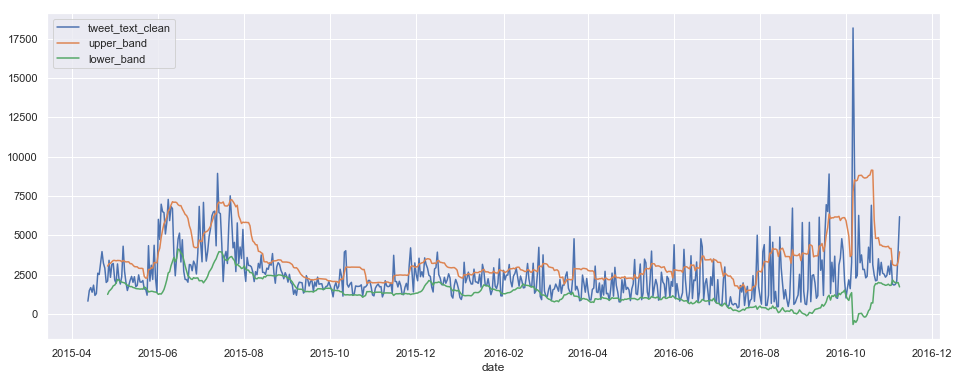

In [467]:
day_tweets[['tweet_text_clean','upper_band','lower_band']].plot(figsize=(16,6))
plt.show()

In [468]:
day_tweets['events'] = day_tweets.apply(lambda x:  x['upper_band'] <= x['tweet_text_clean'], axis = 1)

In [469]:
events_date = {}
i=-1
for index, row in day_tweets.iterrows():
    if row['events']:
        if day_tweets.loc[last_index,'events']:
            events_date[i].append(index)
        else:
            i=i+1
            events_date[i] = [ index ] 
    last_index = index

In [470]:
print('%s events detected'%(len(events_date)))

71 events detected


#### Categorize events
Evaluate the correlation between events and tweets subject 

In [408]:
# import fastText model
dim_space = 3
N_grams = 4
model = fastText.load_model(PATH_DATA + '/fasttext_' + str(dim_space) + '_' + str(N_grams)+'.vec')
# import vocab
nb_words = 4000
corr = 0.75
with open(PATH_DATA+ '/dictionary_+' + str(nb_words) + '_'+ str(corr)+'.pkl', 'rb') as handle:
    vocab = pickle.load(handle)

In [629]:
def get_analogies(vocab_a, model_a,vector,nb_words):
    analogy = {}
    for word in dict(vocab_a.vocab_uncorralated):
        similarity = get_similarity(vector,model_a.get_word_vector(word))
        analogy[word] = np.abs(similarity)
    return dict([w, [analogy[w], vocab_a.vocab_uncorralated[w]]] for w in sorted(analogy, key=analogy.get, reverse=True)[: nb_words])

def get_similarity(vector1,vector2):
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    if norm1 == 0. or norm2 == 0.:
        return 0.
    return np.dot(vector1,vector2)/(norm1 * norm2)
    
def get_normalized(model_n,sentence):
    vector = model_n.get_sentence_vector(sentence)
    norm = np.linalg.norm(vector)
    #if norm != 0.:
     #   vector = vector/np.linalg.norm(vector)
    return vector

[datetime.date(2015, 4, 27)]


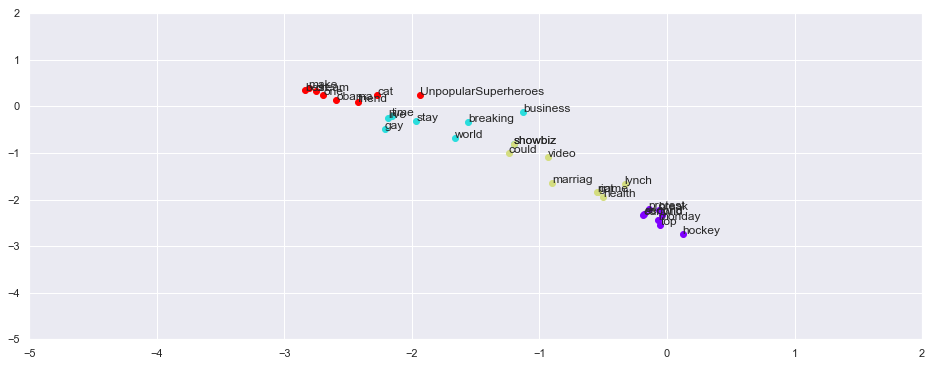

[datetime.date(2015, 5, 7)]


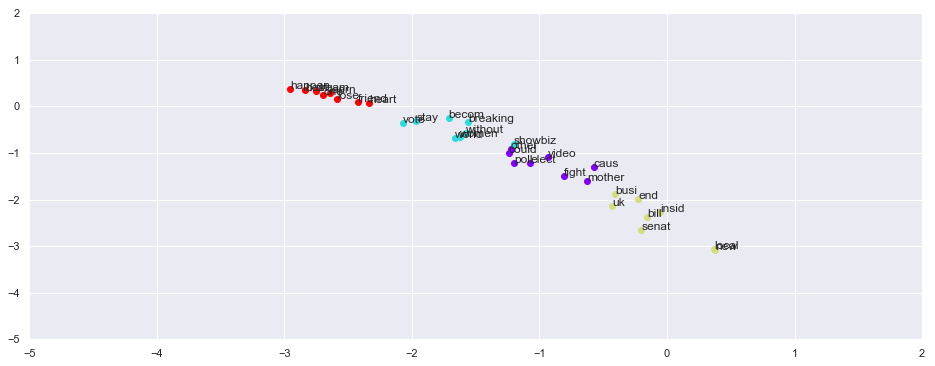

[datetime.date(2015, 5, 25)]


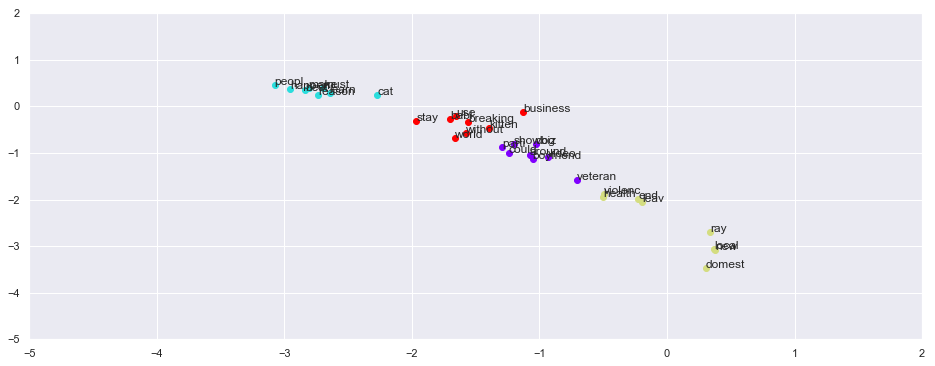

[datetime.date(2015, 5, 27)]


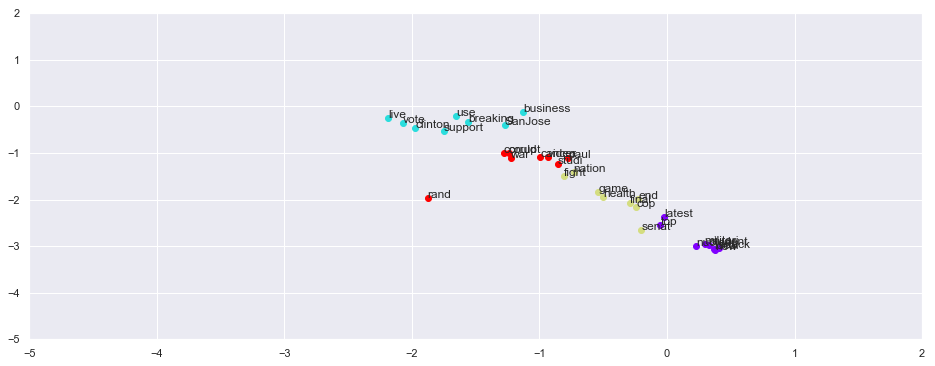

[datetime.date(2015, 5, 29)]


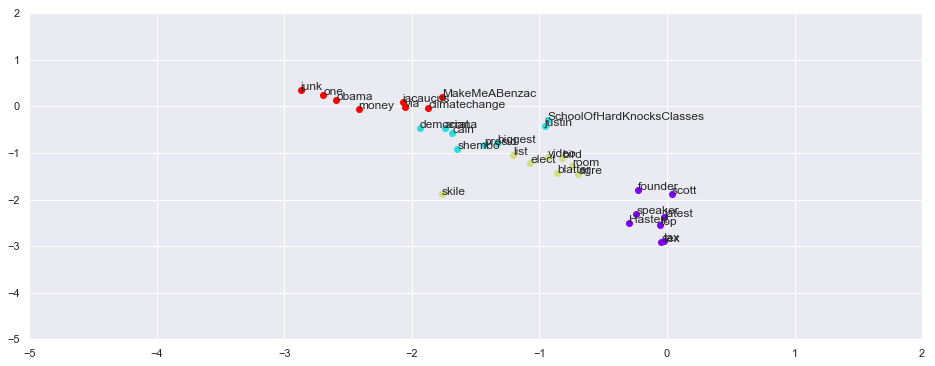

[datetime.date(2015, 6, 1), datetime.date(2015, 6, 2), datetime.date(2015, 6, 3), datetime.date(2015, 6, 4), datetime.date(2015, 6, 5)]


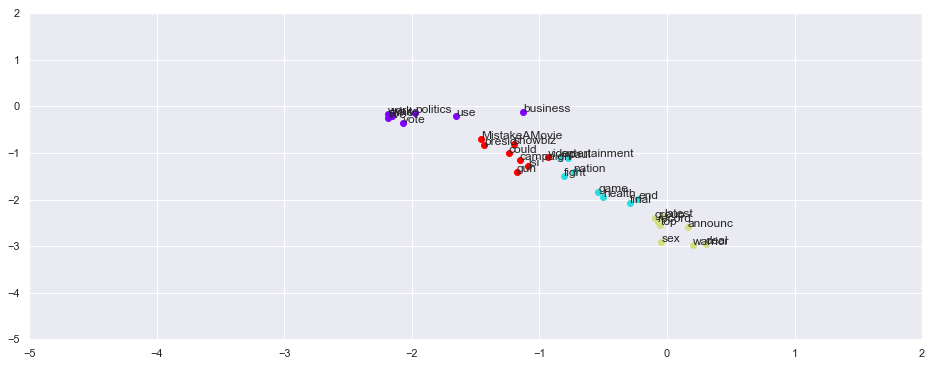

[datetime.date(2015, 6, 8)]


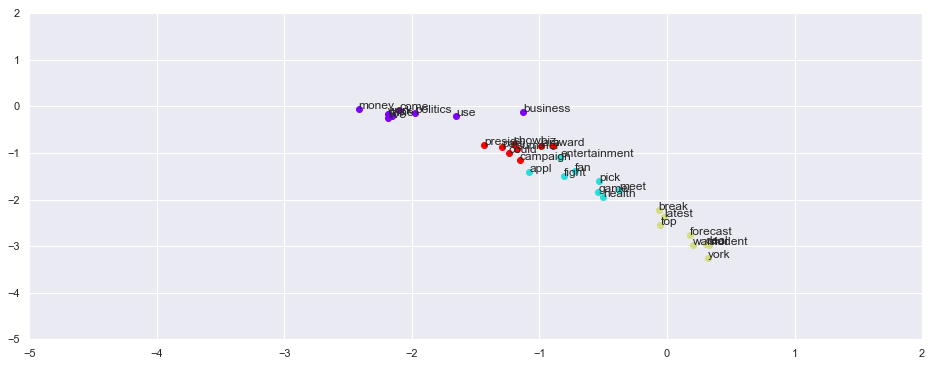

[datetime.date(2015, 6, 30)]


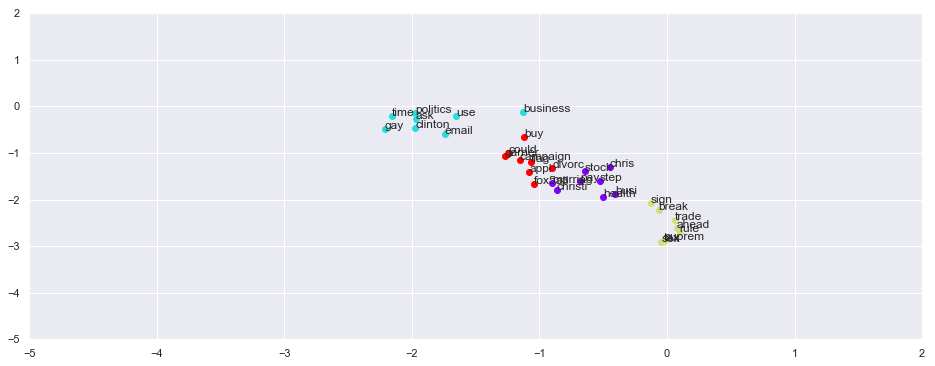

[datetime.date(2015, 7, 3)]


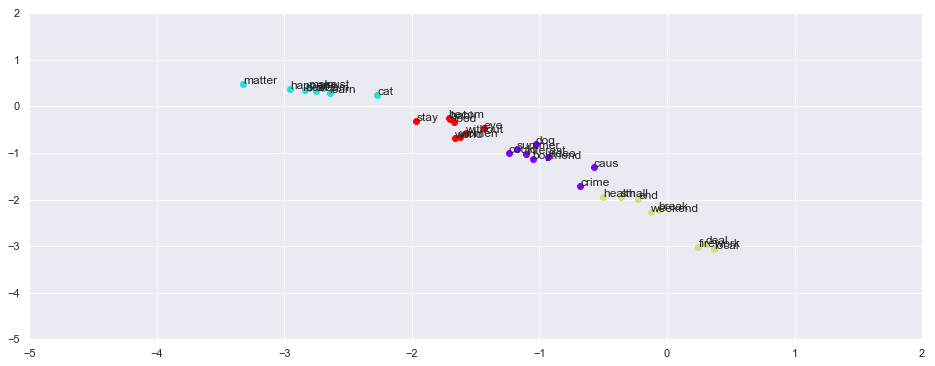

[datetime.date(2015, 7, 9), datetime.date(2015, 7, 10), datetime.date(2015, 7, 11)]


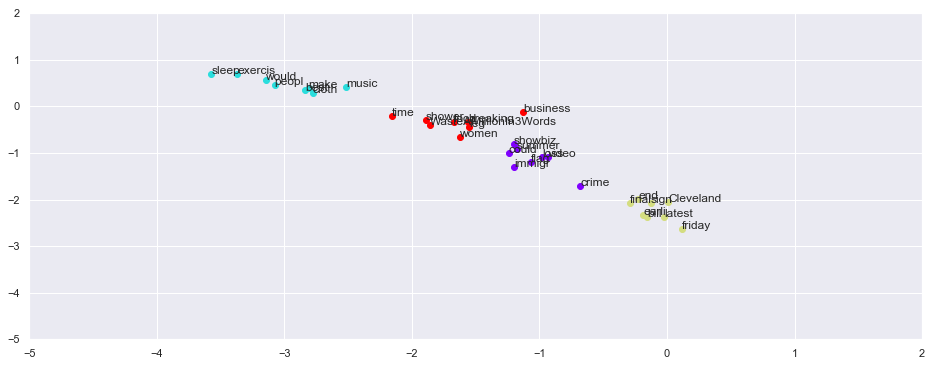

[datetime.date(2015, 7, 13)]


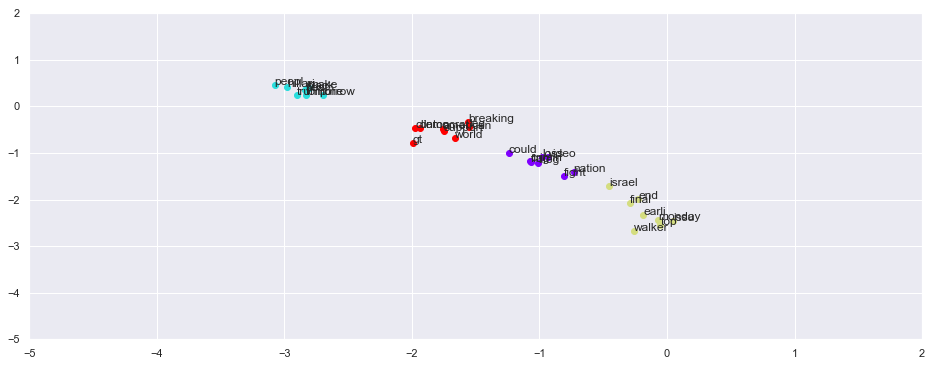

[datetime.date(2015, 7, 22)]


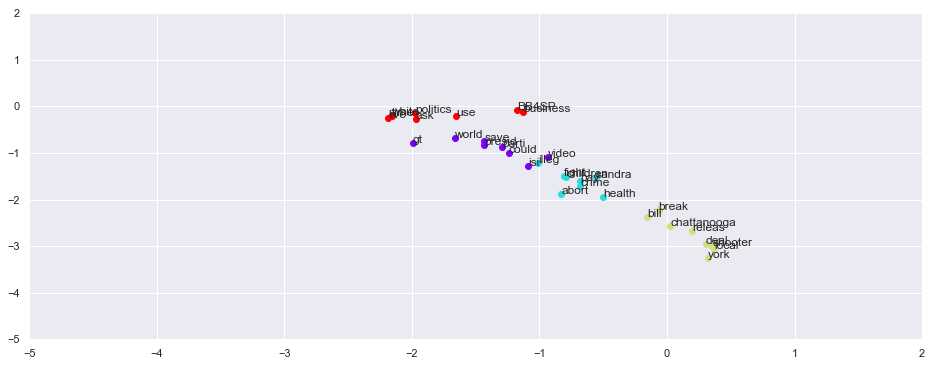

[datetime.date(2015, 8, 21)]


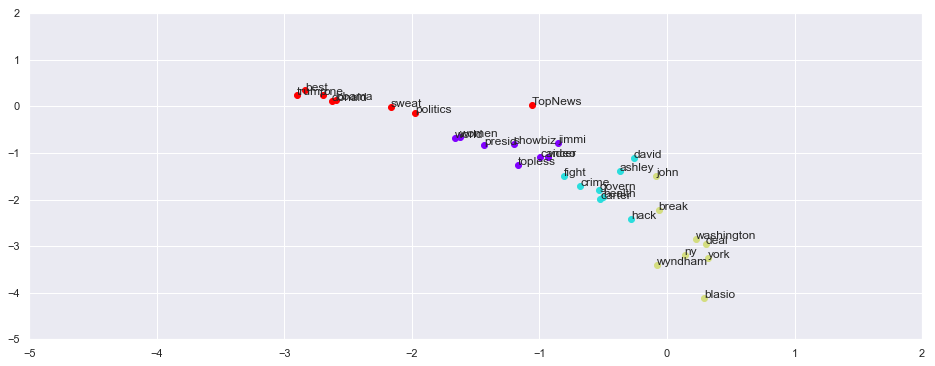

[datetime.date(2015, 9, 14)]


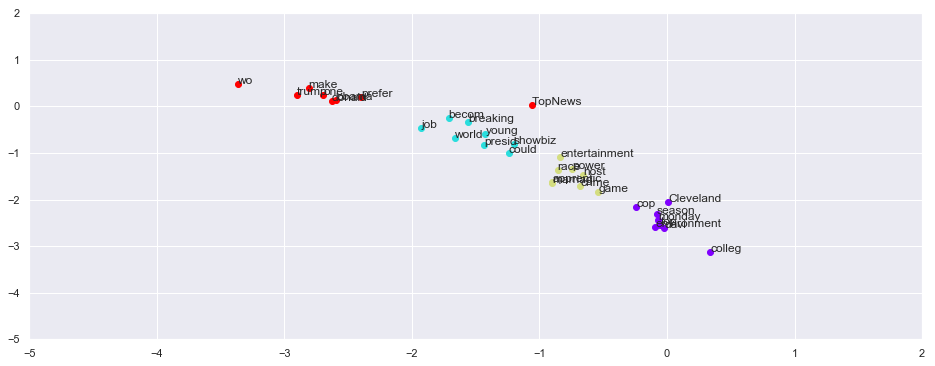

[datetime.date(2015, 9, 22)]


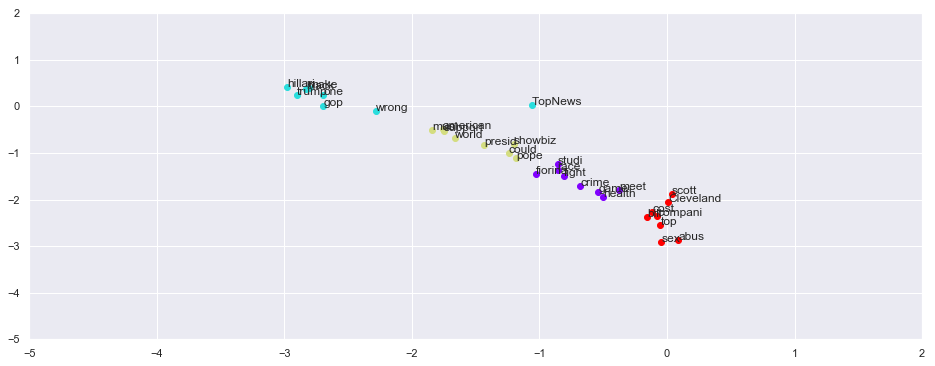

[datetime.date(2015, 10, 8), datetime.date(2015, 10, 9)]


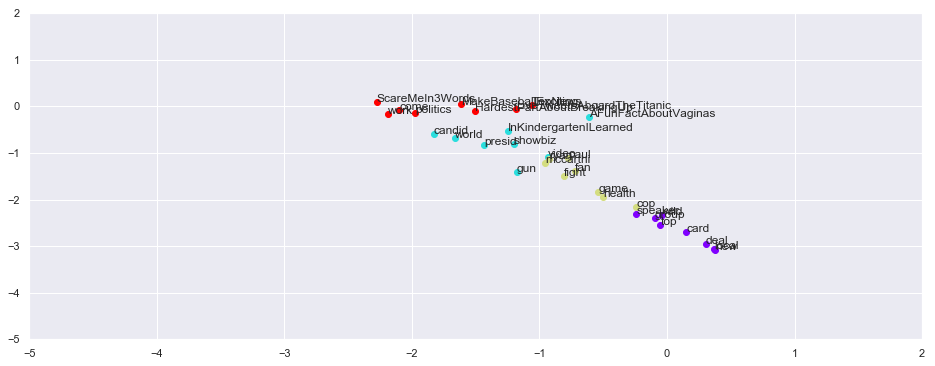

[datetime.date(2015, 10, 11), datetime.date(2015, 10, 12)]


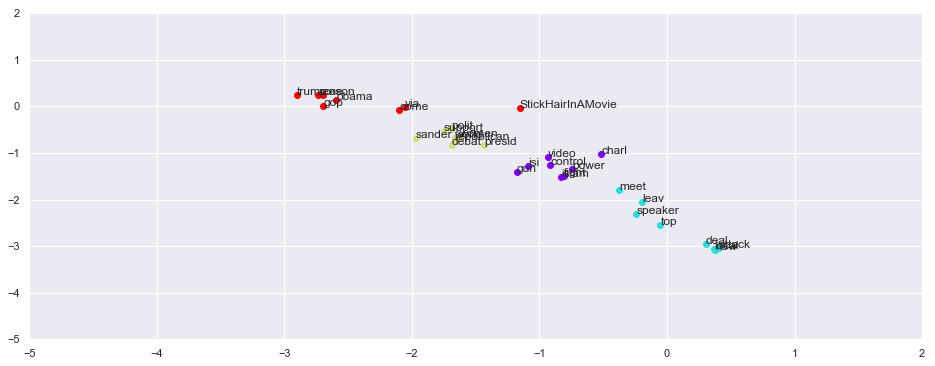

[datetime.date(2015, 10, 28), datetime.date(2015, 10, 29)]


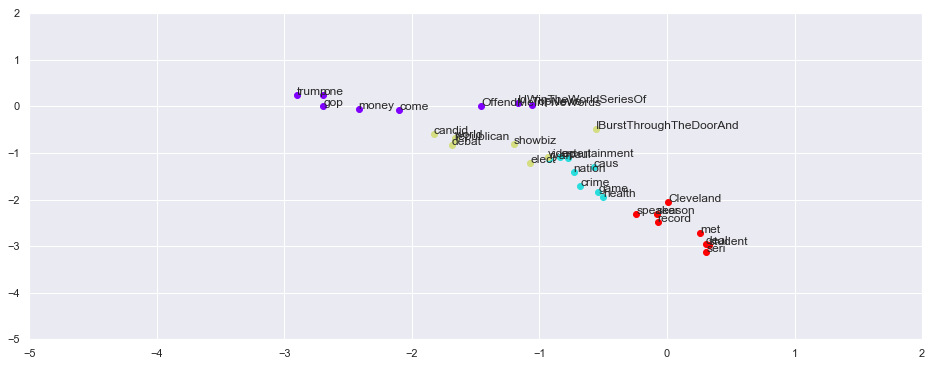

[datetime.date(2015, 11, 9)]


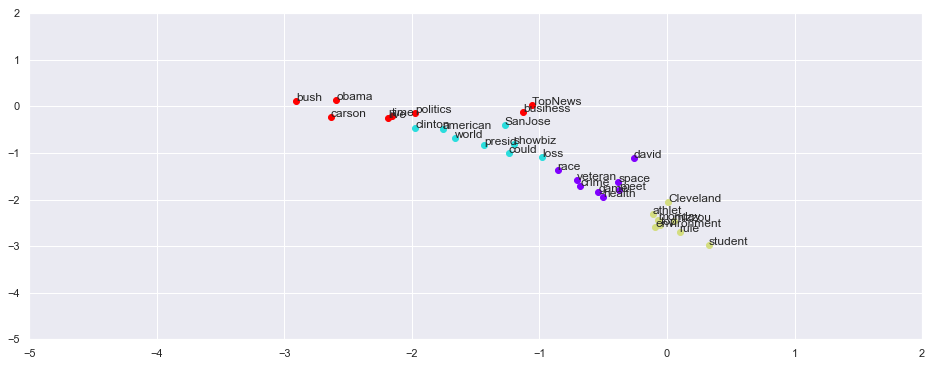

[datetime.date(2015, 11, 13)]


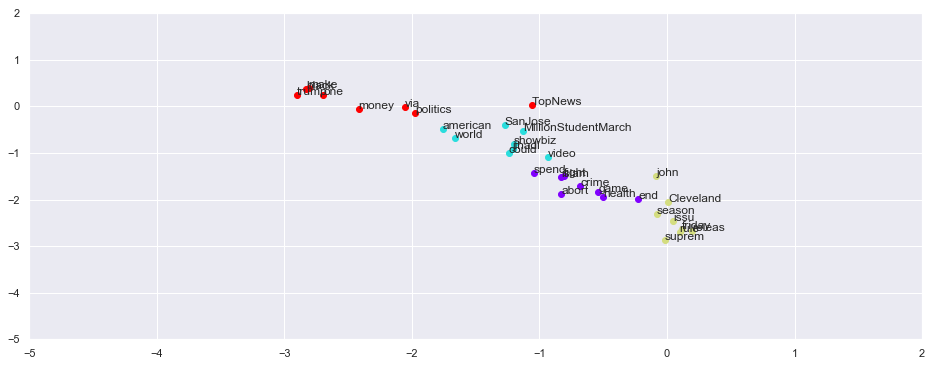

[datetime.date(2015, 11, 15)]


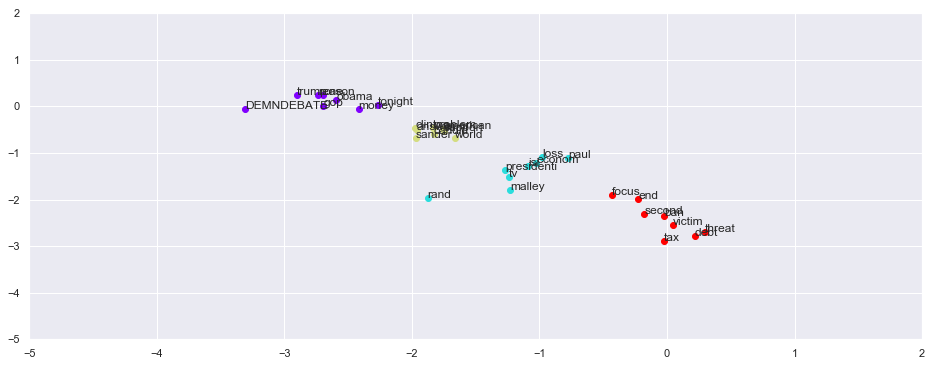

[datetime.date(2015, 11, 26), datetime.date(2015, 11, 27)]


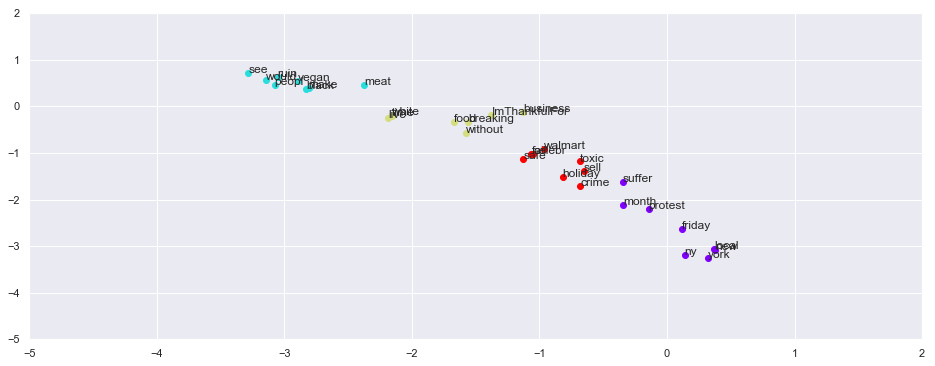

[datetime.date(2015, 11, 30)]


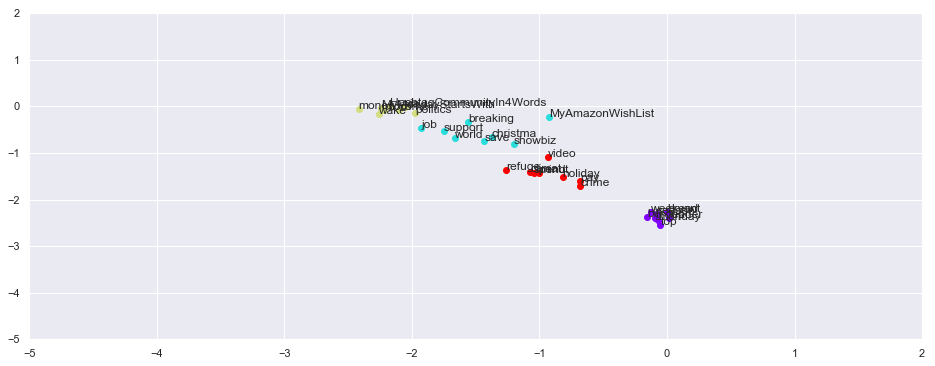

[datetime.date(2015, 12, 3)]


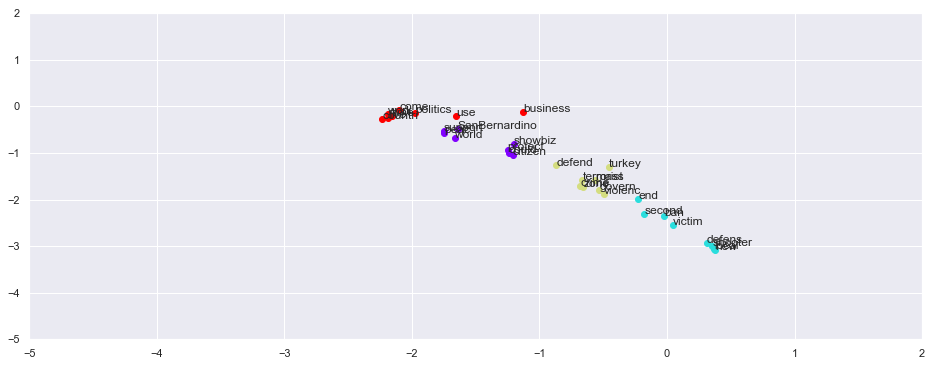

[datetime.date(2015, 12, 7)]


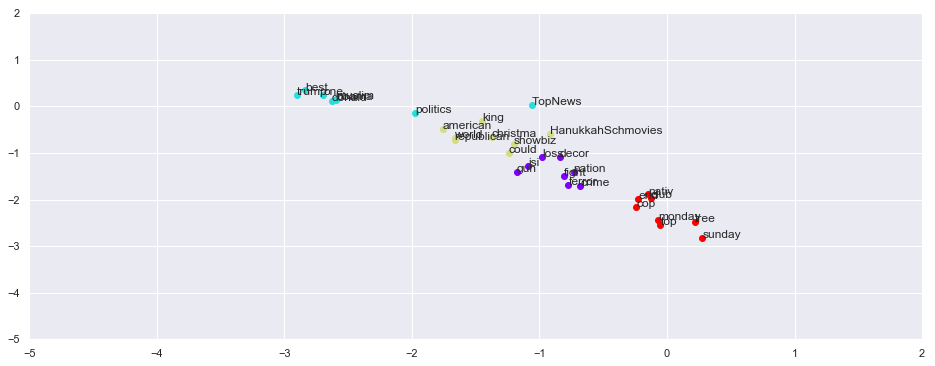

[datetime.date(2015, 12, 16)]


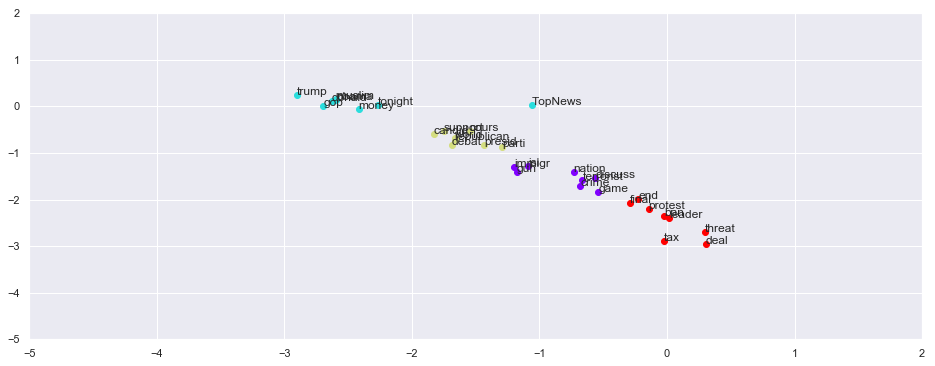

[datetime.date(2016, 1, 4)]


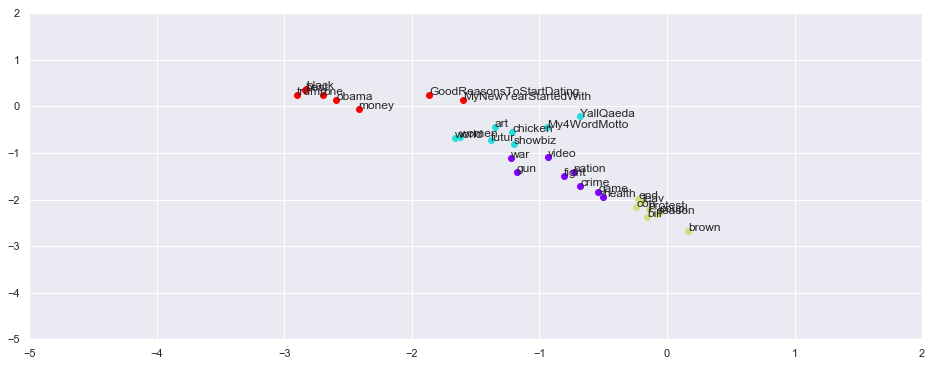

[datetime.date(2016, 1, 7)]


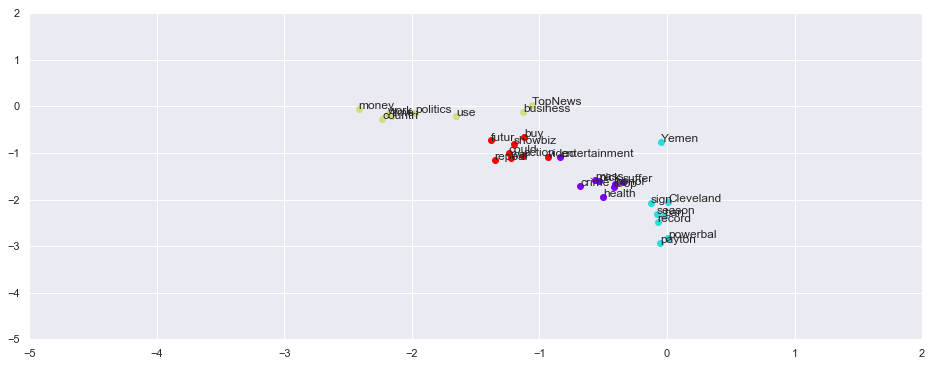

[datetime.date(2016, 1, 11)]


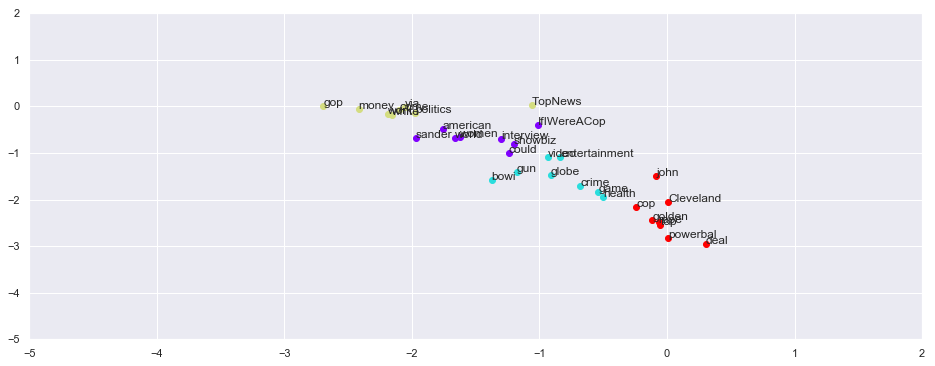

[datetime.date(2016, 1, 17)]


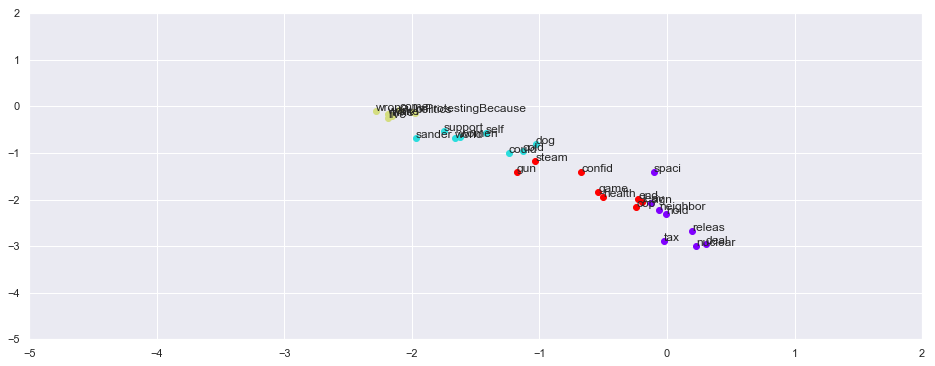

[datetime.date(2016, 1, 25)]


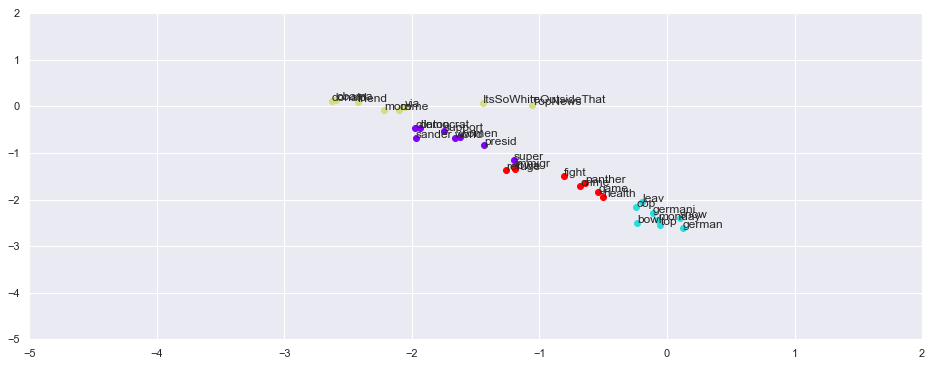

[datetime.date(2016, 1, 29)]


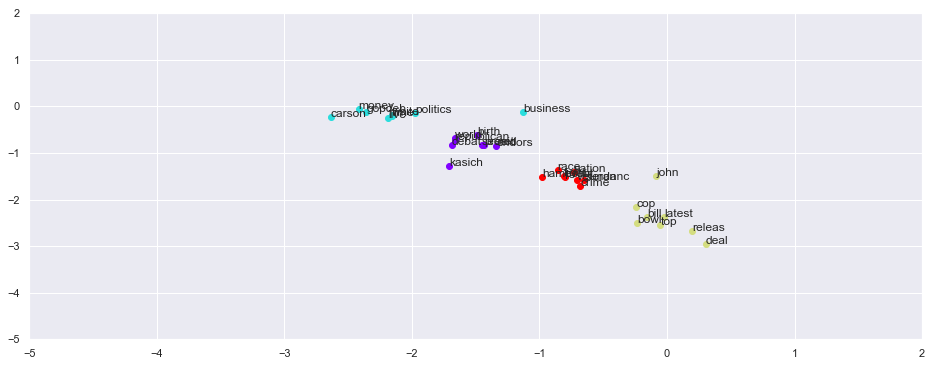

[datetime.date(2016, 2, 1)]


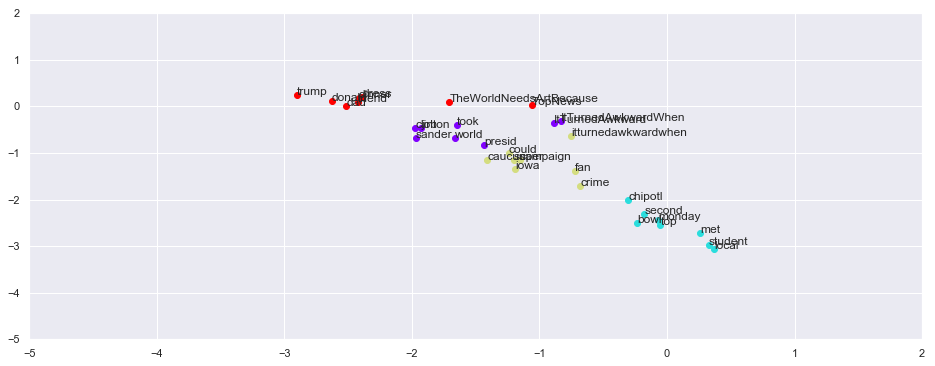

[datetime.date(2016, 2, 5)]


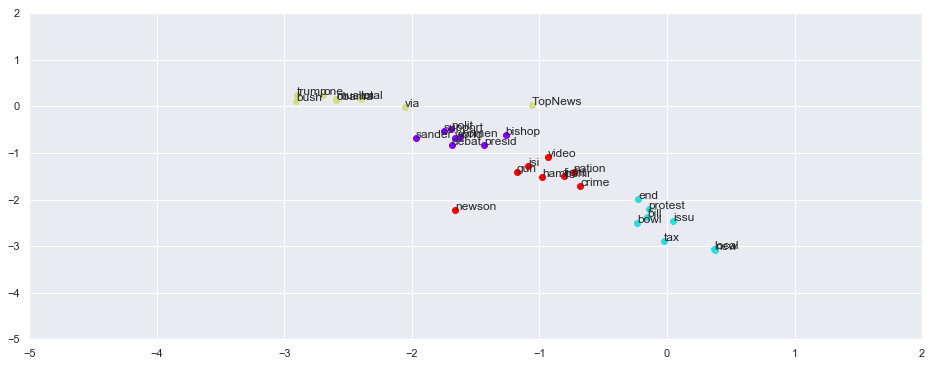

[datetime.date(2016, 2, 18)]


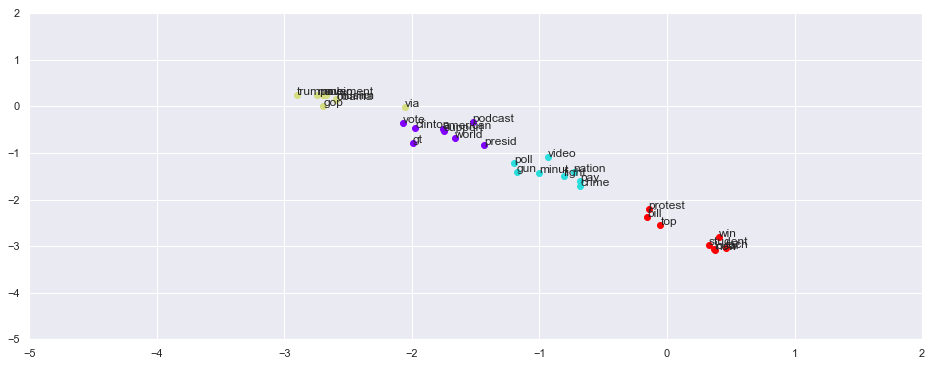

[datetime.date(2016, 2, 22)]


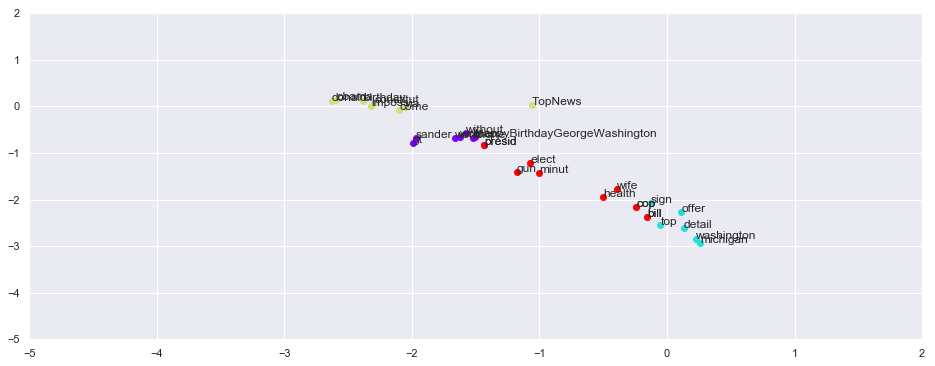

[datetime.date(2016, 2, 26)]


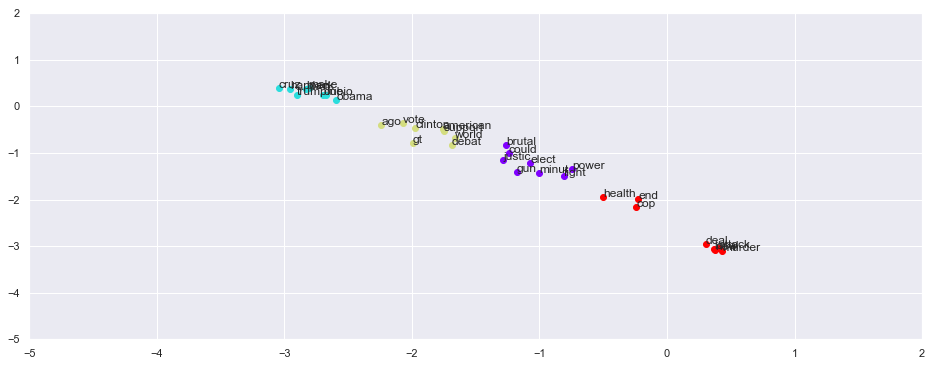

[datetime.date(2016, 2, 29)]


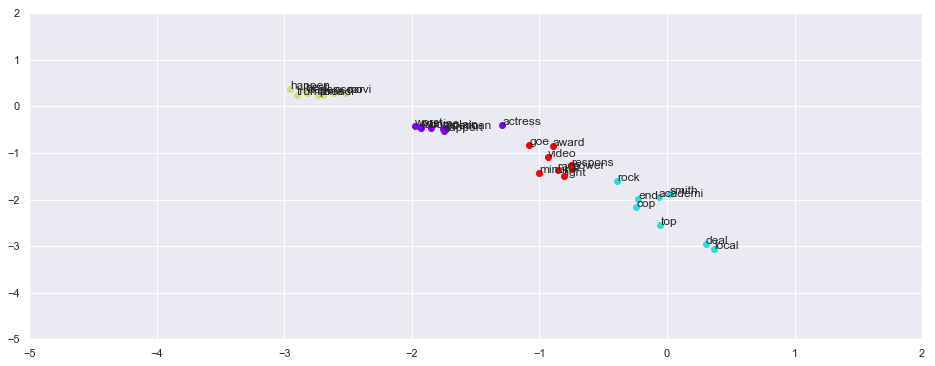

[datetime.date(2016, 3, 16), datetime.date(2016, 3, 17)]


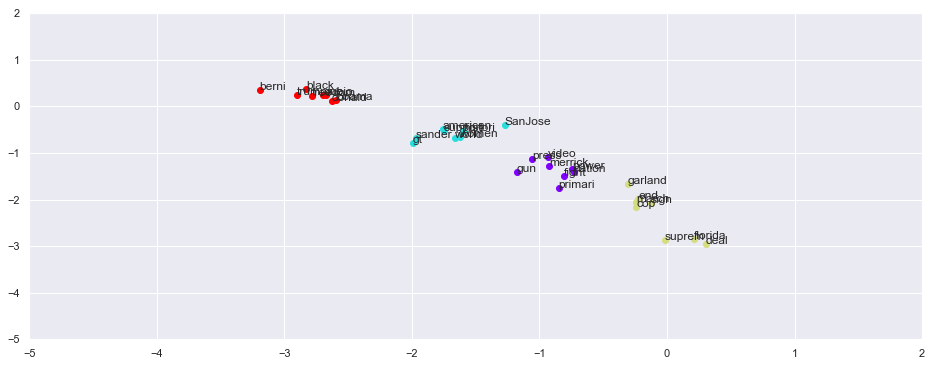

[datetime.date(2016, 3, 22)]


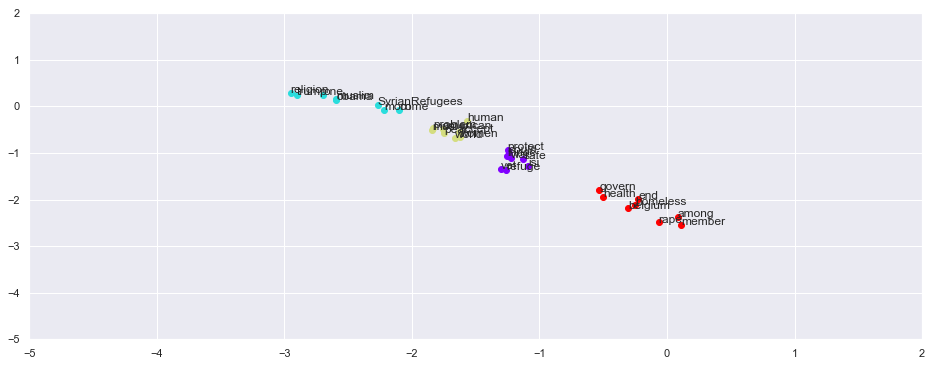

[datetime.date(2016, 4, 6)]


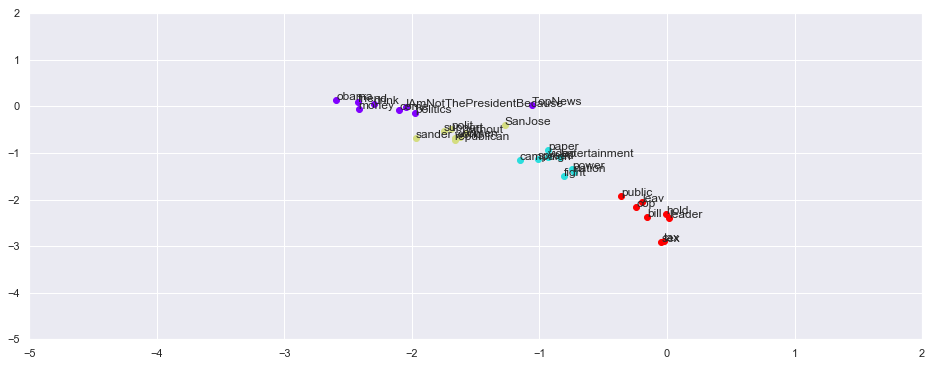

[datetime.date(2016, 4, 13)]


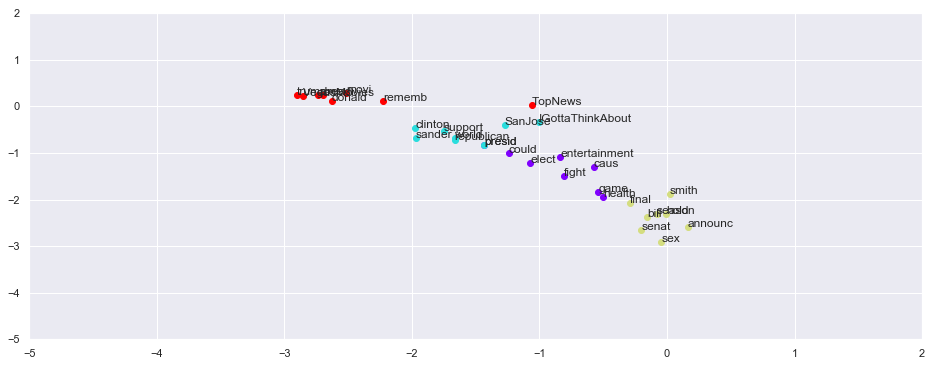

[datetime.date(2016, 4, 18)]


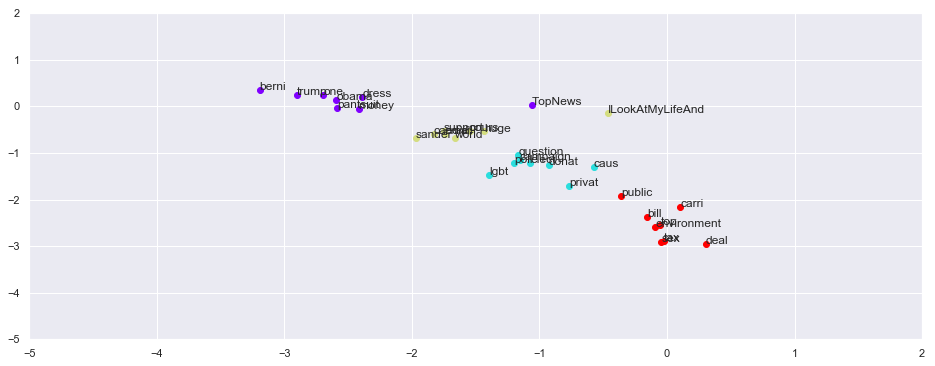

[datetime.date(2016, 4, 20)]


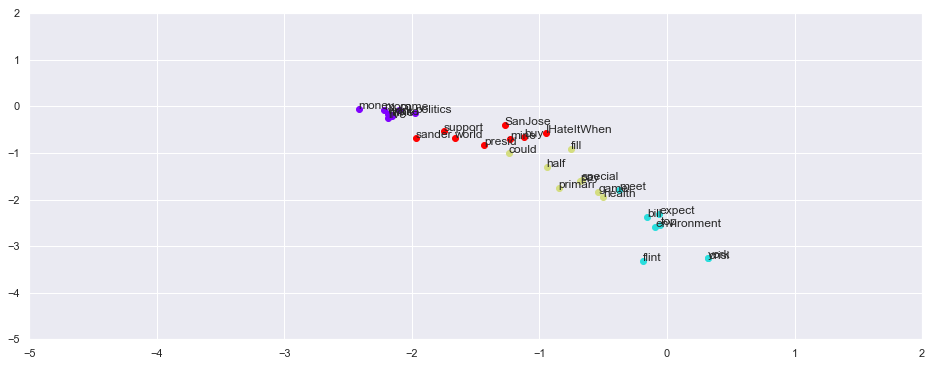

[datetime.date(2016, 5, 4)]


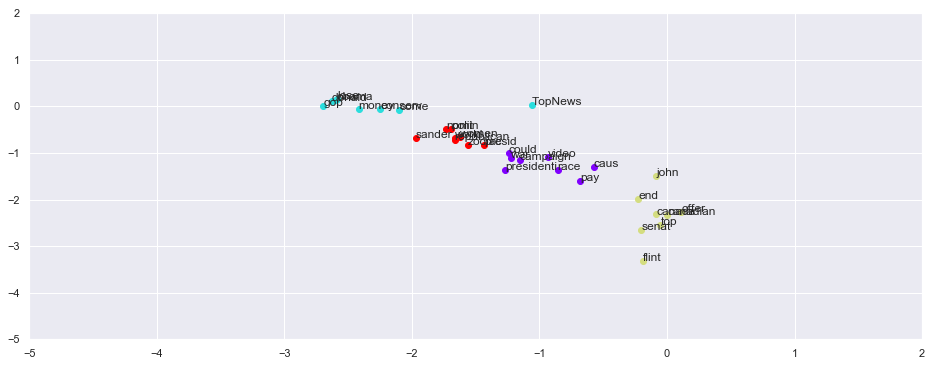

[datetime.date(2016, 5, 8)]


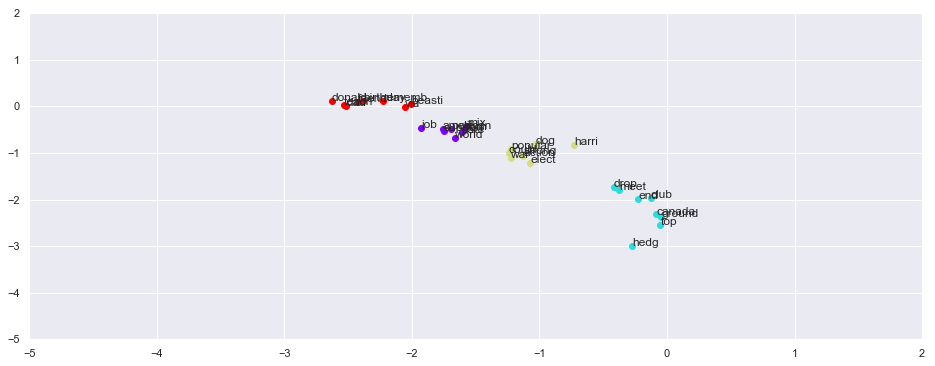

[datetime.date(2016, 5, 11), datetime.date(2016, 5, 12)]


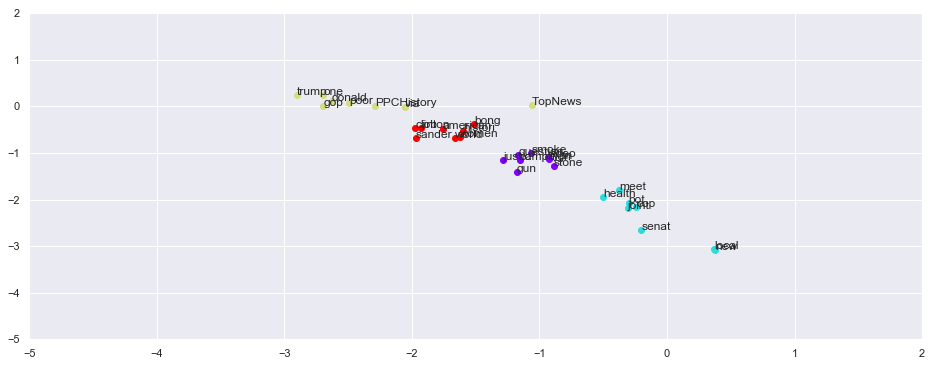

[datetime.date(2016, 5, 16)]


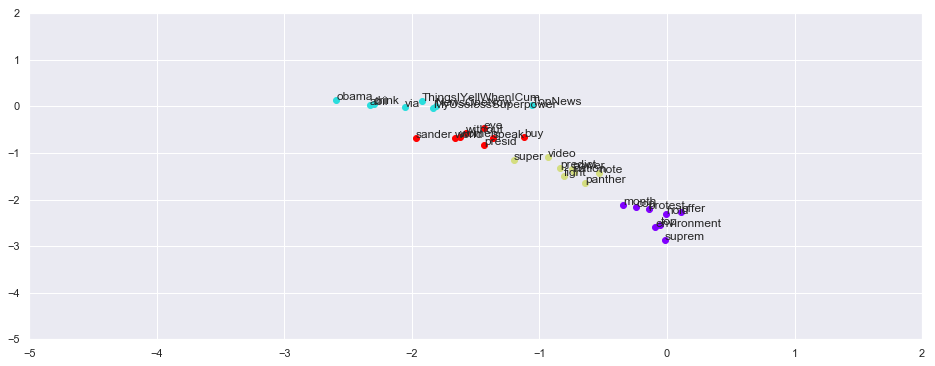

[datetime.date(2016, 6, 1)]


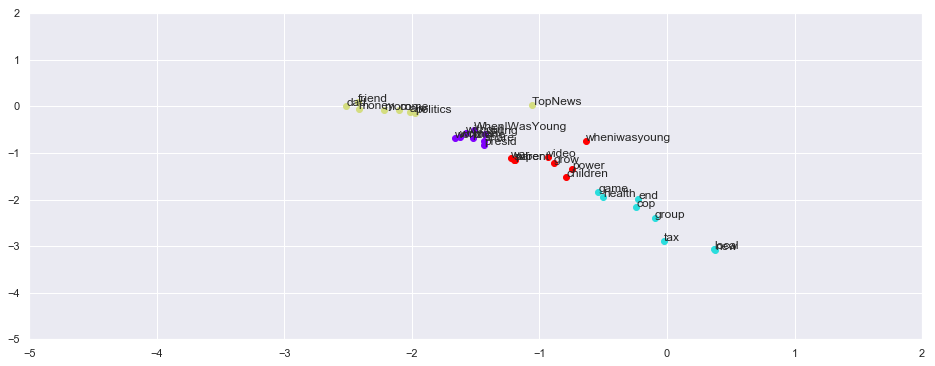

[datetime.date(2016, 6, 8)]


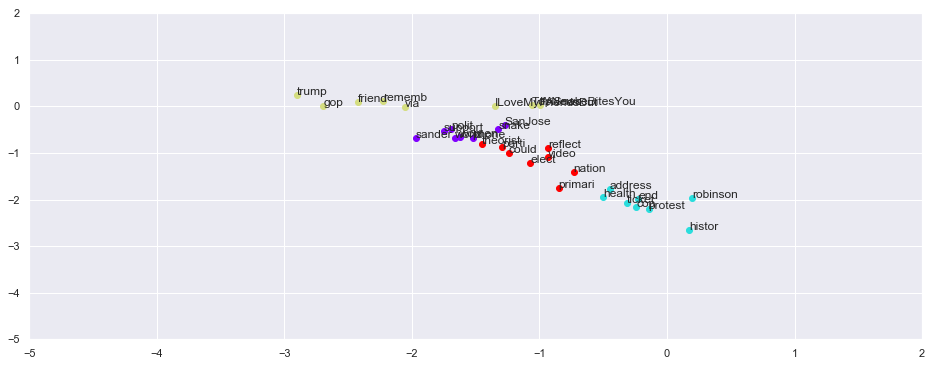

[datetime.date(2016, 6, 13)]


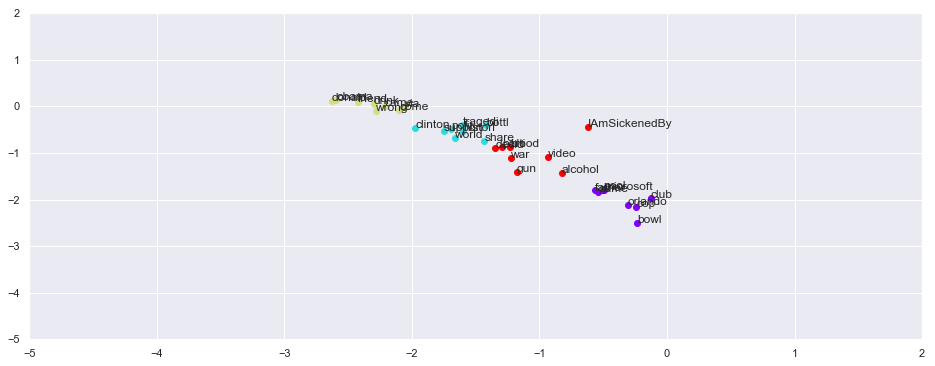

[datetime.date(2016, 6, 17)]


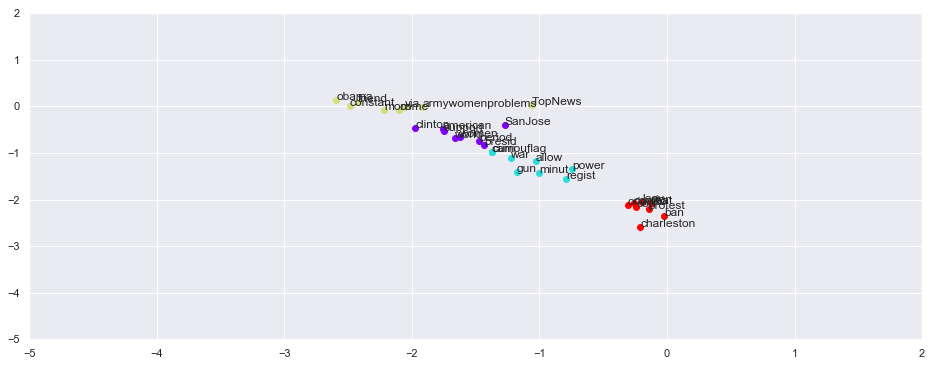

[datetime.date(2016, 6, 20), datetime.date(2016, 6, 21)]


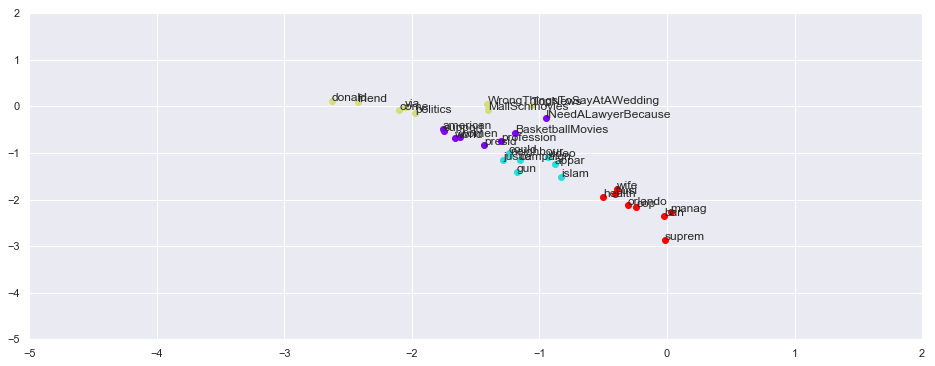

[datetime.date(2016, 6, 29)]


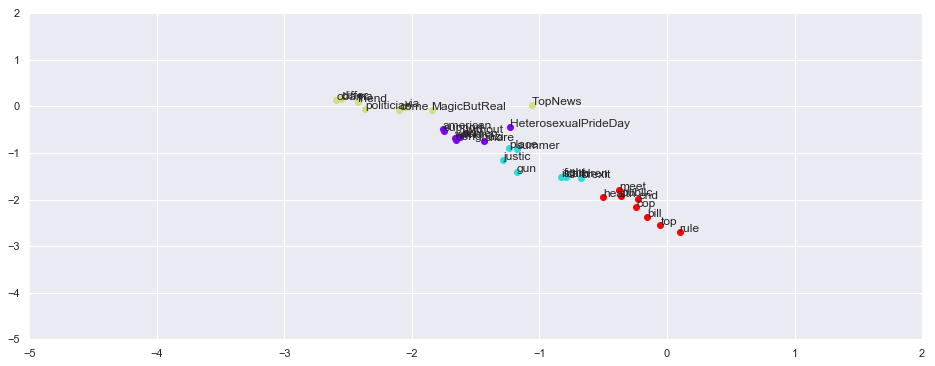

[datetime.date(2016, 7, 7)]


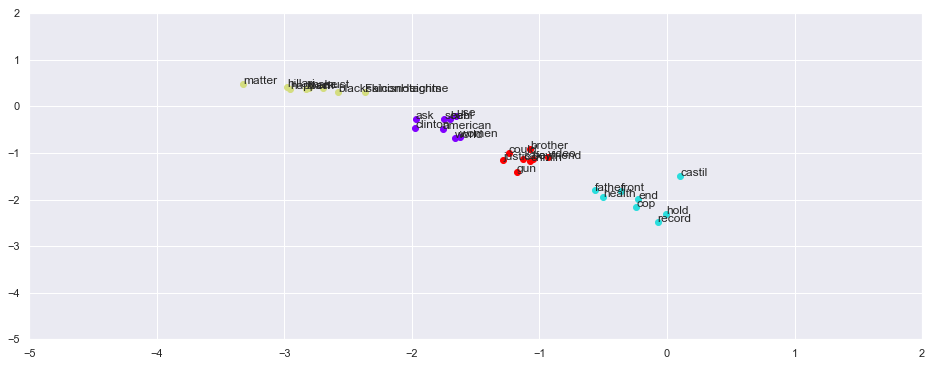

[datetime.date(2016, 7, 18)]


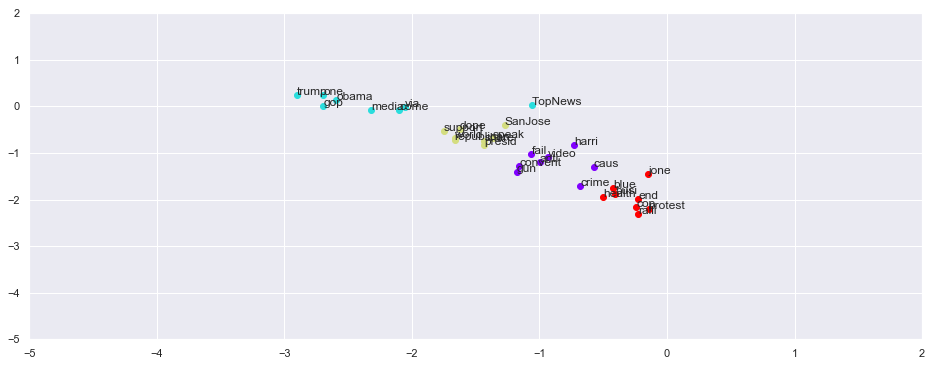

[datetime.date(2016, 7, 20)]


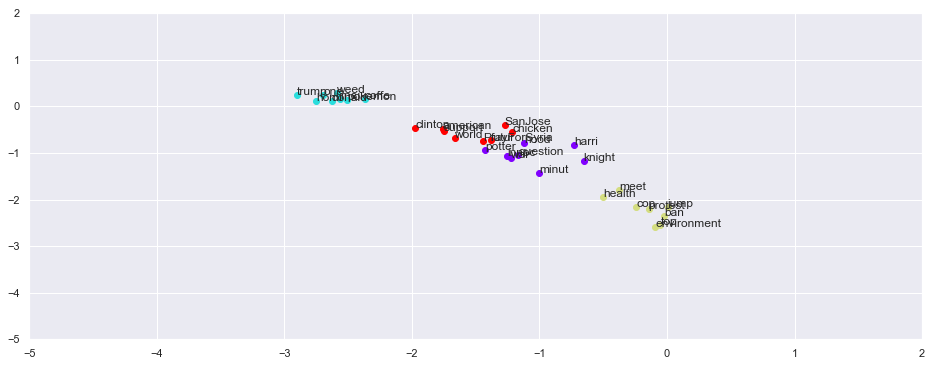

[datetime.date(2016, 7, 23)]


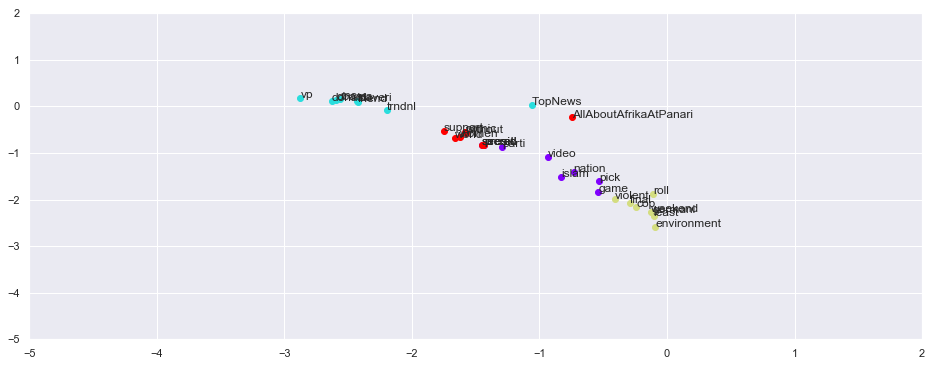

[datetime.date(2016, 7, 27)]


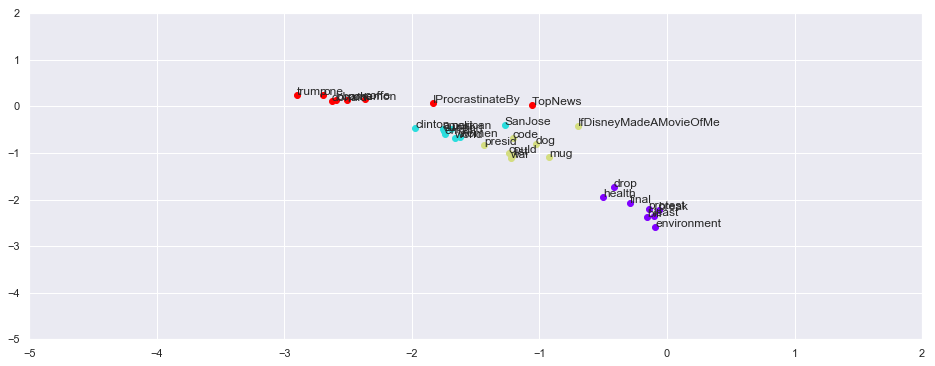

[datetime.date(2016, 7, 29), datetime.date(2016, 7, 30)]


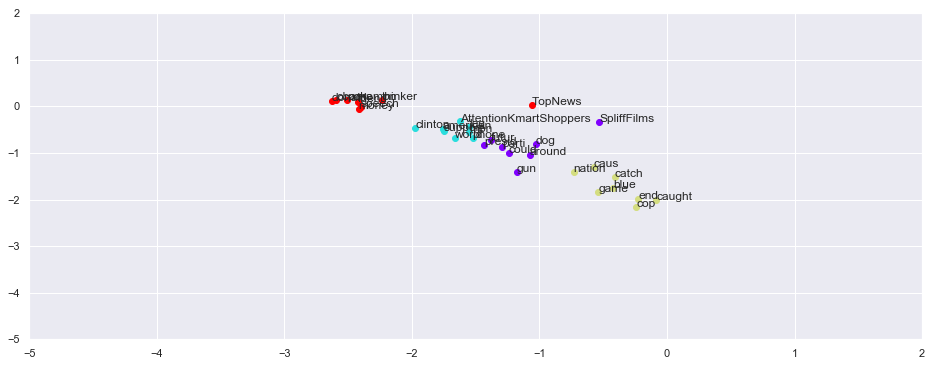

[datetime.date(2016, 8, 3), datetime.date(2016, 8, 4)]


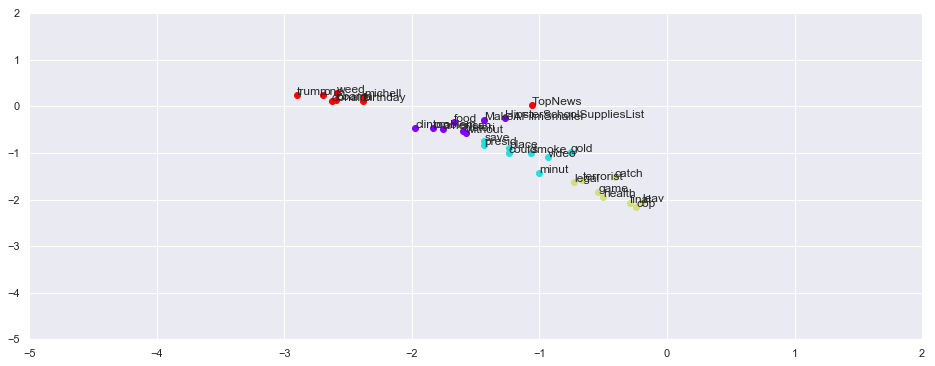

[datetime.date(2016, 8, 8)]


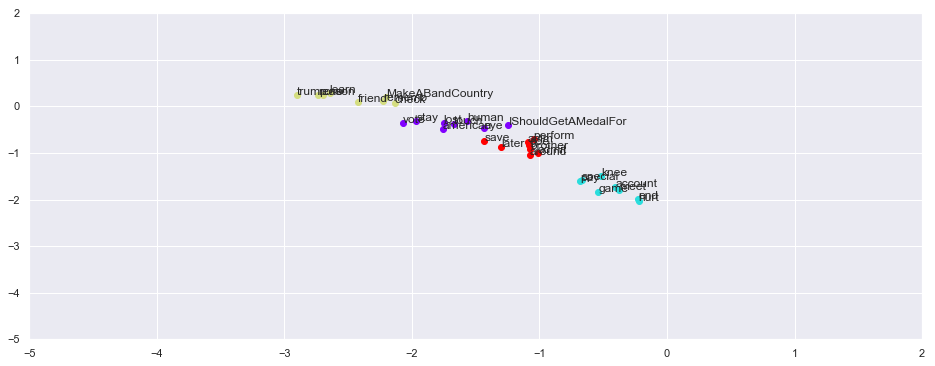

[datetime.date(2016, 8, 10)]


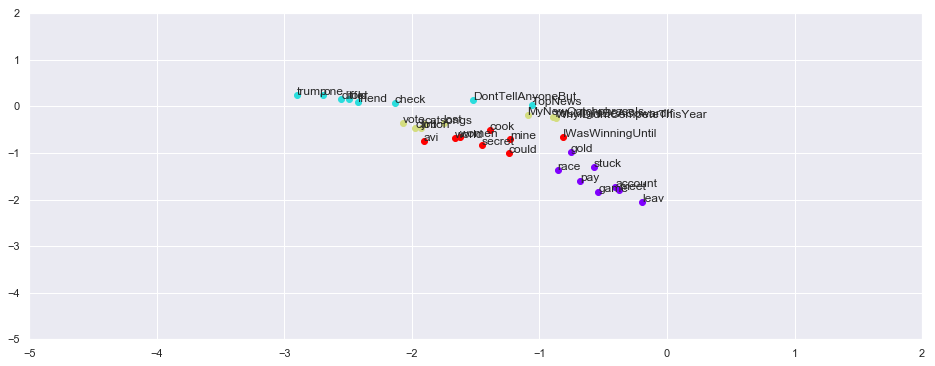

[datetime.date(2016, 8, 15)]


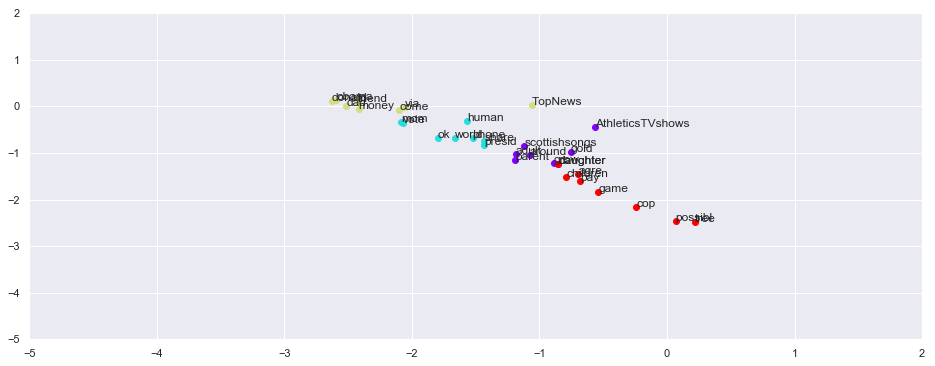

[datetime.date(2016, 8, 23), datetime.date(2016, 8, 24)]


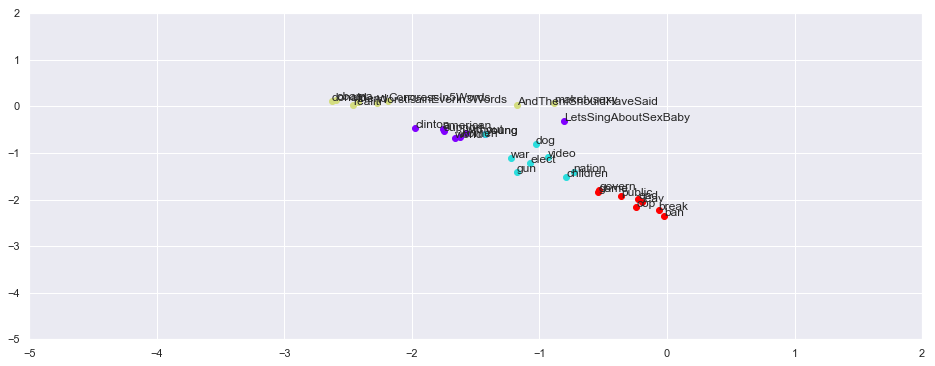

[datetime.date(2016, 8, 31)]


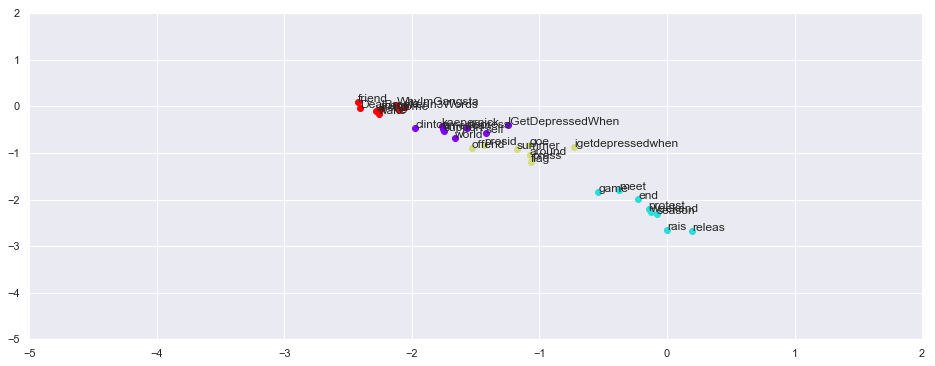

[datetime.date(2016, 9, 5)]


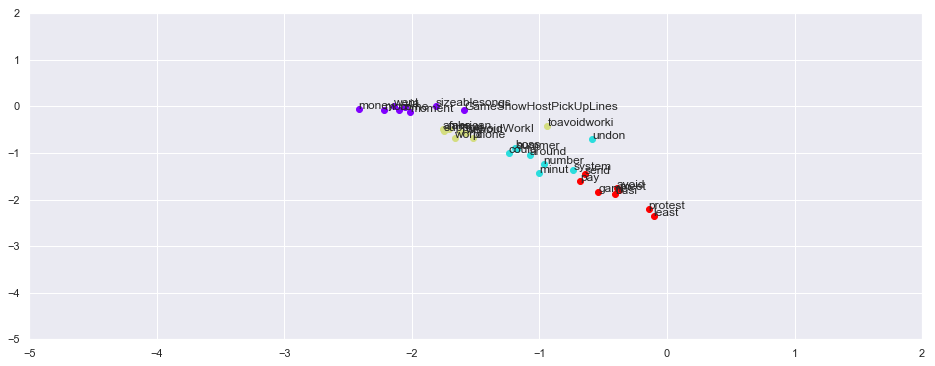

[datetime.date(2016, 9, 12)]


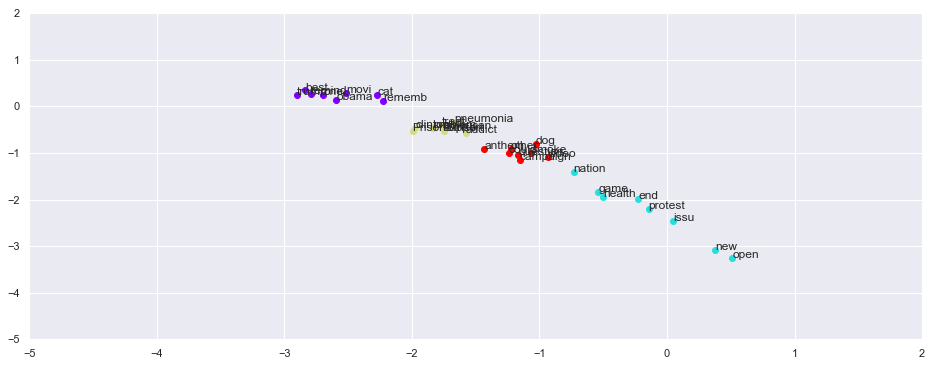

[datetime.date(2016, 9, 16), datetime.date(2016, 9, 17), datetime.date(2016, 9, 18), datetime.date(2016, 9, 19)]


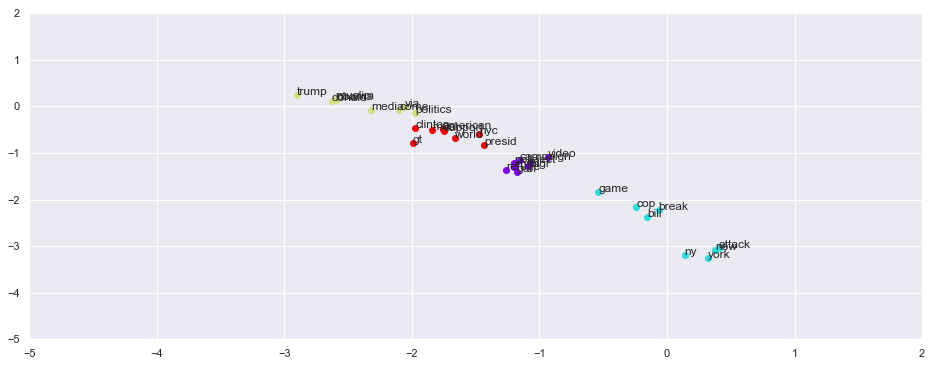

[datetime.date(2016, 10, 6), datetime.date(2016, 10, 7)]


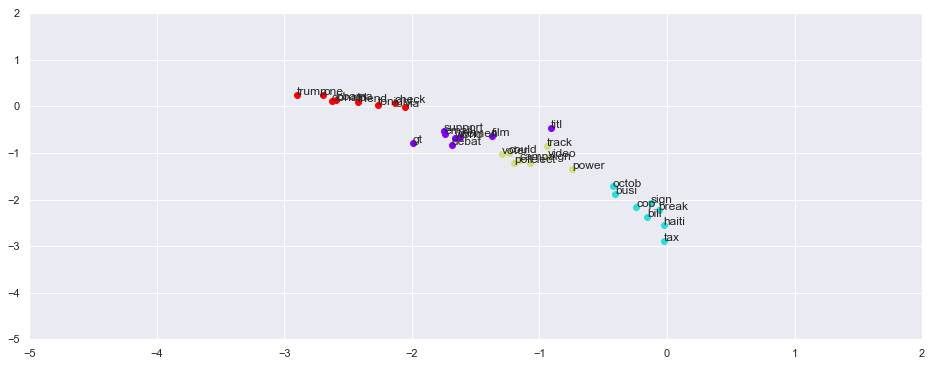

[datetime.date(2016, 11, 7), datetime.date(2016, 11, 8)]


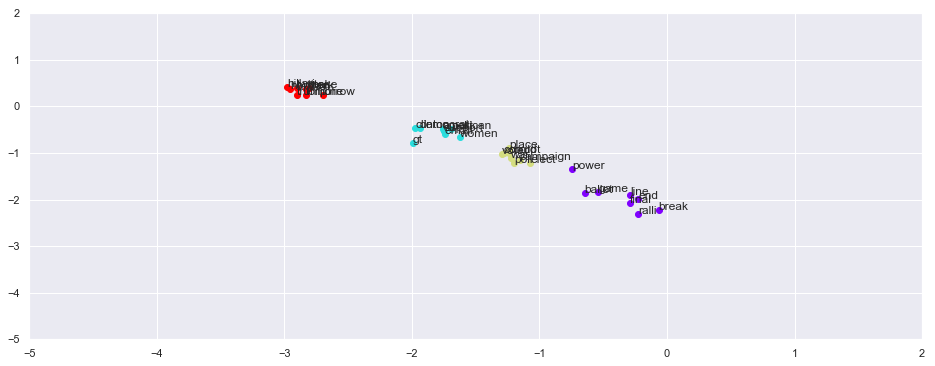

In [640]:
category_dict = {}
nb_clusters = 4
for event in events_date:
    print(events_date[event])
    events_dict = {}
    index = dataset['date'].isin(events_date[event])
    X = dataset.loc[index].apply(lambda x: get_normalized(model,x['tweets_stem']),axis = 1)
    kmeans = KMeans(n_clusters=nb_clusters).fit(X.values.tolist())
    vocab_events = Vocab(dataset.loc[index,['date','words_stem','hashtags','tweets_stem']],
                         100,corr = 0.7, uncorralated=False)
    #plt.scatter(np.array(X.values.tolist())[:,0], np.array(X.values.tolist())[:,1],s =0.01)
    #plt.show()
    vocab_events.unselect_word = vocab.unselect_word
    vocab_events.vocab_uncorralated = vocab_events.delete_corralated()
    for cluster in range(nb_clusters):
        events_dict[cluster] = {'event': events_date[event], 
                                'vector':kmeans.cluster_centers_[cluster],
                                'number':(kmeans.labels_ == cluster).sum(),
                                'words': get_analogies(vocab_events,model,kmeans.cluster_centers_[cluster],30)}
    display_cluster(vocab_events, model, kmeans.cluster_centers_,8)
    category_dict[event] = events_dict

In [626]:
category_dict 

{0: {0: {'event': [datetime.date(2015, 4, 27)],
   'number': 744,
   'vector': array([-0.52771891, -0.81841272]),
   'words': {u'baltimor': [0.7323722081777778, 124],
    u'break': [0.8560109506551545, 24],
    'breaking': [0.7093902866176585, 82],
    u'could': [0.9491424692951094, 40],
    u'death': [0.6948108009730785, 40],
    u'die': [0.7316397789066008, 30],
    u'draft': [0.7236440164074924, 24],
    u'earli': [0.880698549657584, 22],
    u'end': [0.8960432380317149, 23],
    u'fall': [0.7246557424092165, 26],
    u'game': [0.9585092685734337, 68],
    u'gay': [0.7084419778931221, 25],
    u'health': [0.9488948277452954, 59],
    u'hockey': [0.8154996543594745, 22],
    u'hurt': [0.8944281648024075, 36],
    u'local': [0.7691004217434663, 214],
    u'lynch': [0.9303574260850501, 30],
    u'marriag': [0.9974440249546249, 23],
    u'monday': [0.8562448280505709, 22],
    u'new': [0.7683559534128827, 78],
    u'offer': [0.8126923948703006, 24],
    u'open': [0.7457206389129547, 22]

In [637]:
def display_cluster(vocab, model, cluster_vector,nb_words):
    dim = model.get_dimension()
    nb_clusters = cluster_vector.shape[0]
    colors = cm.rainbow(np.linspace(0, 1, nb_clusters))
    plt.figure(figsize=(16,6))
    for cluster in range(nb_clusters):
        arr = np.empty((nb_words,dim), dtype='f')
        word_labels = []
        # get close words
        close_words = get_analogies(vocab, model, cluster_vector[cluster,:],nb_words)

        # add the vector for each of the closest words to the array

        for word_, i in zip(close_words, range(nb_words)):
            arr[i,:] = model.get_word_vector(word_)
            word_labels.append(word_)


        plt.scatter(arr[:, 0], arr[:, 1], c = colors[cluster])
        if nb_words <=20:
            for label, x, y in zip(word_labels, arr[:, 0], arr[:, 1]):
                plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(-5,2)
    plt.ylim(-5,2)
    plt.show()

In [580]:
display_cluster(vocab, model,model.get_word_vector('hilari'),1000000)

IndexError: too many indices for array

### 6.2. Tweets classification

Using the scandale above, we will plan to analyze the hashtags on the keyword described above. We will try to develop a method to classify the virality of a tweet.

### 6.3 Impact on the voting intentions

Using the voter survey, and the results above, we will try to see if the viral tweets described above have impacted the voting intentions or not.

## Analysis

In [228]:
def impact (row):
      return row['quote_count']+row['reply_count']+row['like_count']+row['retweet_count']+math.sqrt(row['follower_count'])

In [229]:
def sentiment(row):
    vs = analyzer.polarity_scores(row['tweet_text_clean'])
    return list(vs.values())

In [230]:
data_analysis = dataset[['account_category','userid','tweet_time','tweet_text_clean','quote_count','reply_count','like_count','retweet_count','follower_count']]

data_analysis['impact_score'] = data_analysis.apply (lambda row: impact (row),axis=1)
data_analysis["rolling_mean"] = np.nan

analyzer = SentimentIntensityAnalyzer()
data_analysis['tweet_sentiment'] = data_analysis.apply(lambda row:sentiment(row), axis=1)
sentiments_ind = pd.DataFrame(data_analysis['tweet_sentiment'].tolist(), columns=['neg', 'neu','pos','compound'])
data_analysis = pd.concat([data_analysis,sentiments_ind],axis=1)
data_analysis = data_analysis.drop(['quote_count','reply_count','like_count','retweet_count','follower_count','tweet_sentiment'],axis=1)
data_analysis['tweet_time'] = pd.to_datetime(data_analysis['tweet_time']).dt.date

In [231]:
def roller(group):
    group['rolling_mean']=group['impact_score'].rolling(window=10).mean()
    return(group)

In [232]:
grouped_data = data_analysis.groupby(['account_category','userid'],as_index=False).apply(lambda x:x.sort_values('tweet_time'))
grouped_data = grouped_data.groupby(['account_category','userid']).apply(lambda x:roller(x))
grouped_data['tweet_time'] = pd.to_datetime(grouped_data['tweet_time']).dt.date

In [233]:
account_categories = pd.unique(grouped_data['account_category'])
sentiment_types = ['Negative','Neutral','Positive','Compound']

### Visualization

In [234]:
meanimpact = grouped_data.groupby('account_category')['impact_score'].mean()
data = [go.Bar(x=account_categories,y=meanimpact)]
layout = go.Layout(title = 'Mean impact score for each troll category'
    xaxis=dict(title='Account category'),
    yaxis=dict(title='Impact score'))
fig = go.Figure(data=data, layout=layout)
plotly.offline.plot(fig, filename=PATH_DATA+'mean_impact_cat.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datamean_impact_cat.html'

In [235]:
dfsentcat = grouped_data[['account_category','neg', 'neu','pos','compound']]
dfsentcat = dfsentcat.groupby('account_category').mean()

data = []
for indice, short_sentiment in enumerate(['neg', 'neu','pos','compound']):
    trace = go.Bar(
        x=list(dfsentcat.index),
        y=dfsentcat[short_sentiment],
        name=sentiment_types[indice])
    data.append(trace)

layout = go.Layout(title = 'Mean tweet sentiment scores for each troll category',
                   yaxis=dict(title='Score'),
                   barmode='group')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')
plotly.offline.plot(fig, filename=PATH_DATA+'sentiment_category.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datasentiment_category.html'

In [236]:
myscatters = {}
colorvect = ['#e8ae00','#93928f','#4286f4','#2b8740']
visibility = True
for category in account_categories:
    df = grouped_data[['userid','tweet_time','neg', 'neu','pos','compound']][grouped_data['account_category']==category]
    top_user_count = df.groupby('userid').count().sort_values(by='neg',ascending=False).iloc[0,0]
    df = df.groupby('userid')['tweet_time','neg', 'neu','pos','compound'].filter(lambda x: len(x) == top_user_count)
    df = df.groupby('tweet_time').mean()
    myscatters[category] = {}
    if category!=account_categories[0]:
        visibility = False
    for indice, short_sentiment in enumerate(['neg', 'neu','pos','compound']):
        myscatters[category][short_sentiment] = go.Scatter(x=list(df.index),
                                                           y=df[short_sentiment].rolling(window=5).mean(),
                                                           mode = 'lines',
                                                           visible=visibility,
                                                           name=sentiment_types[indice]+' sentiment',
                                                           line=dict(color=colorvect[indice]))

In [237]:
data = []
for category in account_categories:
    for short_sentiment in ['neg', 'neu','pos','compound']:
        data.append(myscatters[category][short_sentiment])

buttons = []       
for indice,category in enumerate(account_categories):
        visible = [True if x in range(indice*4,(indice+1)*4) else False for x in range(32)]
        category_dict = dict(label = category,
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': 'Sentiment categorization of the tweets in the most active '+category+' account type'}])
        buttons = buttons+[category_dict]

updatemenus = list([
    dict(type="dropdown",
         active=-1,
         buttons=buttons)
])

layout = dict(title='Tweet sentiment for most active user as a fonction of time', showlegend=True, yaxis=dict(title='Sentiment score'),
              updatemenus=updatemenus)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='sentiment_time')
plotly.offline.plot(fig, filename=PATH_DATA+'sentiment_time.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datasentiment_time.html'

In [259]:
hist = grouped_data.groupby('userid')['userid'].count().sort_values(ascending=False)
data = [go.Bar(y=hist)]
layout = go.Layout(title='Number of tweets for each user account',
    xaxis=dict(title='User'),
    yaxis=dict(title='Number of tweets'))
fig = dict(data=data, layout=layout)
plotly.offline.plot(fig, filename=PATH_DATA+'histo_user.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datahisto_user.html'

In [260]:
#Scandals with keywords
milestones = pd.DataFrame(columns = ['date','keywords'])
milestones['date'] = pd.to_datetime(['09/09/2016', '11/09/2016','28/10/2016', '30/10/2016','30/07/2016','01/10/2016',
                                     '07/10/2016','12/04/2015', '16/06/2015', '08/09/2015','09/02/2016','18/02/2016',
                                     '26/05/2016','09/06/2016','26/09/2016','09/10/2016','19/10/2016'], dayfirst=True)
milestones['keywords'] = ['clinton deplorables electors trump','clinton pneumonia stumble malaise','fbi emails clinton',
                         'pizzagate clinton pedophilia podesta', 'trump khan soldier iraq', 'trump tax', 'trump tape access hollywood',
                         'clinton launch campaign','trump launch campaign','clinton apologize emails','sanders win','trump pope christianity wall', 'trump delegate threshold',
                         'obama clinton','first presidential debate','second presidential debate','third presidential debate']
milestones['scandal_name'] = ['Clinton insults Trump electors','Clinton malaise','FBI Clinton emails',
                         'Pizzagate: Podesta pedophilia', 'Trump disrespects US soldier', 'Trump tax', 'Trump tape "Access Hollywood"',
                         'Clinton launches campaign','Trump launches campaign','Clinton apologize for the emails','Sanders major win','Pope doesn"t consider Trump christian', 'Trump reaches delegate threshold',
                         'Obama endorses Clinton','First presidential debate','Second presidential debate','Third presidential debate']
milestones['date']=milestones['date'].dt.date
milestones = milestones.sort_values(by='date')

In [243]:
#Compare twittos activity per category for each scandal
data = []
milestones = milestones.sort_values(by='date')
visibility = True
for indice,event in enumerate(milestones['date'].sort_values()):
    if indice!=0:
        visibility = False
    df = data_analysis[['account_category','tweet_time']][data_analysis['tweet_time']==event]
    df = df.groupby('account_category')['account_category'].count()
    data.append(go.Bar(x=list(df.index),y=df,visible=visibility))

In [244]:
#Plotly syntax for slider
steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        label = str(milestones.iloc[i,0])+': '+ str(milestones.iloc[i,2]),
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(
    visible = True,
    active = 0,
    currentvalue= {
        'font': {'size': 20},
        'prefix': 'Scandal ',
        'visible': True,
        'xanchor': 'right'
    },
    pad = {"t": len(milestones['date'])},
    steps = steps
)]

layout = dict(title='Number of tweets per troll category during the day of the milestone',
              yaxis=dict(title='Score'),
              sliders=sliders)

fig = dict(data=data, layout=layout)

plotly.offline.plot(fig, filename=PATH_DATA+'scandals_compound.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datascandals_compound.html'

In [256]:
#Compare sentiment scores for each category for each scandal
data = []
milestones = milestones.sort_values(by='date')
visibility = True
for indice,event in enumerate(milestones['date'].sort_values()):
    df = data_analysis[['account_category','neg','neu','pos','compound']][data_analysis['tweet_time']==event]
    df = df.groupby('account_category')['neg','pos'].mean()
    if indice!=0:
        visibility = False
    data.append(go.Bar(x=list(df.index),y=df['neg'],name='Negative Sentiment',visible = visibility))
    data.append(go.Bar(x=list(df.index),y=df['pos'],name='Positive Sentiment',visible = visibility))

In [257]:
steps = []
for i in range(round(len(data)/2)):
    step = dict(
        method = 'restyle',
        label = str(milestones.iloc[i,0])+': '+ str(milestones.iloc[i,2]),
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][2*i:2*(i+1)-1] = [True, True]
    steps.append(step)

sliders = [dict(
    visible = True,
    active = 0,
    currentvalue= {
        'font': {'size': 20},
        'prefix': 'Milestone ',
        'visible': True,
        'xanchor': 'right'
    },
    pad = {"t": 20},
    steps = steps
)]

layout = dict(title='Mean positive and negative sentiment score per troll category during the day of the milestone',
              yaxis=dict(title='Score'),
              sliders=sliders)

fig = dict(data=data, layout=layout)

plotly.offline.plot(fig, filename=PATH_DATA+'scandals_compound.html')

'file://C:\\Users\\Aindy\\Downloads\\adams-family-project\\datascandals_compound.html'